Epoch: 0, Loss: 0.3345
Epoch: 1, Loss: 0.3099
Epoch: 2, Loss: 0.2827
Epoch: 3, Loss: 0.2497
Epoch: 4, Loss: 0.2205
Epoch: 5, Loss: 0.2041
Epoch: 6, Loss: 0.1780
Epoch: 7, Loss: 0.1645
Epoch: 8, Loss: 0.1466
Epoch: 9, Loss: 0.1381


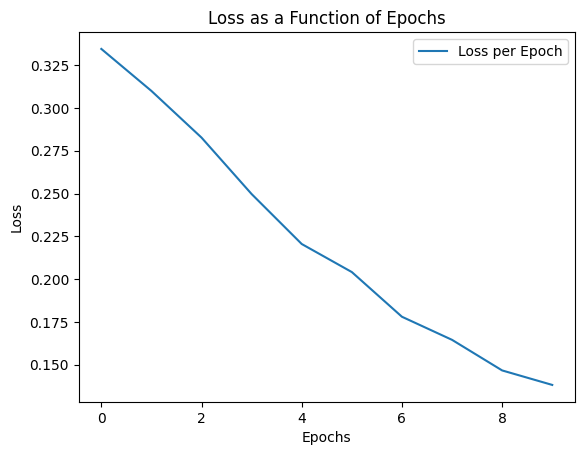

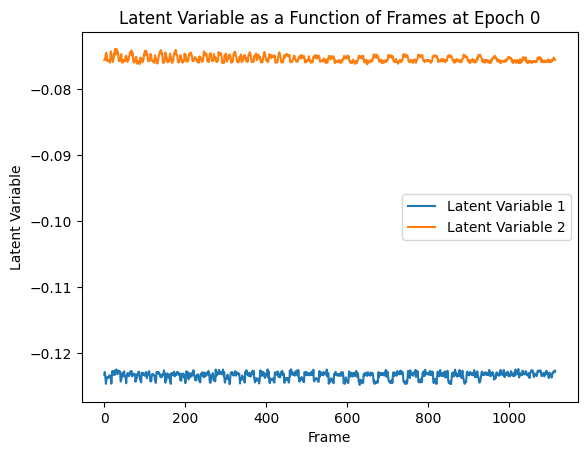

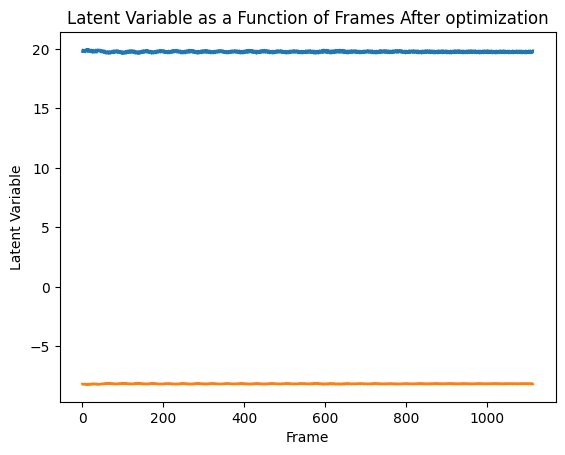

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from data_processing.data_processing2 import images_tensor

class ConvNetAutoencoder_basic(nn.Module):
    def __init__(self, input_shape):
        super(ConvNetAutoencoder_basic, self).__init__()
        self.encoder_conv_layers = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
        )

        self._get_conv_output(input_shape)

        self.encoder_fc_layers = nn.Sequential(
            nn.Linear(self.num_flat_features, 128),
            nn.ELU(),
            nn.Linear(128, 64),
            nn.ELU(),
            nn.Linear(64, 2),
        )

        self.decoder_fc_layers = nn.Sequential(
            nn.Linear(2, 64),
            nn.ELU(),
            nn.Linear(64, 128),
            nn.ELU(),
            nn.Linear(128, self.num_flat_features),
        )

        self.decoder_conv_layers = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
        )
        
    def _get_conv_output(self, shape):
        bs = 1
        input_tensor = torch.randn(bs, *shape)
        with torch.no_grad():
            output_feat = self.encoder_conv_layers(input_tensor)
        self.final_conv_shape = output_feat.shape[1:]
        n_size = output_feat.detach().flatten(start_dim=1).size(1)
        self.num_flat_features = n_size

    def forward(self, x):
        x = self.encoder_conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.encoder_fc_layers(x)
        latent_vars = x.clone()
        x = self.decoder_fc_layers(x)
        x = x.view(x.size(0), *self.final_conv_shape)
        x = self.decoder_conv_layers(x)
        return x, latent_vars


images_tensor = images_tensor

model = ConvNetAutoencoder_basic(input_shape=(1, 200, 560))
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 10
losses = []
patience = 5
min_delta = 0.01
latent_epoch_data = []
converged = False

for epoch in range(num_epochs):
    if converged:
        break
    model.train()
    optimizer.zero_grad()
    reconstructed, latent_vars = model(images_tensor)
    loss = loss_fn(reconstructed, images_tensor)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
    print(f"Epoch: {epoch}, Loss: {loss.item():.4f}")

    if epoch > 0 and (losses[-2] - losses[-1] < min_delta):
        if patience > 0:
            patience -= 1
        else:
            print("Early stopping as the model has converged.")
            converged = True

    if epoch % 50 == 0:
        latent_epoch_data.append(latent_vars.detach().cpu().numpy())

latent_values = []

model.eval()
with torch.no_grad():
    xe = model.encoder_conv_layers(images_tensor)
    xe = xe.view(xe.size(0), -1)
    latent_variable = model.encoder_fc_layers(xe)

latent_values = latent_variable.numpy()

plt.plot(losses, label='Loss per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss as a Function of Epochs')
plt.legend()
plt.show()

for index, latent_vars_at_epoch in enumerate(latent_epoch_data):
    plt.figure()
    for var_idx in range(latent_vars_at_epoch.shape[1]):
        plt.plot(latent_vars_at_epoch[:, var_idx], label=f'Latent Variable {var_idx + 1}')
    plt.xlabel('Frame')
    plt.ylabel('Latent Variable')
    plt.title(f'Latent Variable as a Function of Frames at Epoch {index * 50}')
    plt.legend()
    plt.show()

plt.plot(latent_values)
plt.xlabel('Frame')
plt.ylabel('Latent Variable')
plt.title('Latent Variable as a Function of Frames After optimization')
plt.show()

These are results for when we dont include any physics informed losses our results dont really make sense quantitatevly however they do make sense qualitatively we have oscillations which makes sense since both x and v should be oscillating for our system. (as you can see overfitting is occuring thats why we barely have any oscillations after optimaztion)

Epoch: 0, Total Loss: 0.5737
Epoch: 1, Total Loss: 27.1742
Epoch: 2, Total Loss: 1.3928
Epoch: 3, Total Loss: 0.5473
Epoch: 4, Total Loss: 0.5854
Epoch: 5, Total Loss: 0.6127
Epoch: 6, Total Loss: 0.5388
Epoch: 7, Total Loss: 0.4964
Epoch: 8, Total Loss: 0.4879
Epoch: 9, Total Loss: 0.4776
Epoch: 10, Total Loss: 0.3785
Epoch: 11, Total Loss: 0.3037
Epoch: 12, Total Loss: 0.2594
Epoch: 13, Total Loss: 0.2147
Epoch: 14, Total Loss: 0.2576
Epoch: 15, Total Loss: 0.1907
Epoch: 16, Total Loss: 0.1477
Epoch: 17, Total Loss: 0.1137
Epoch: 18, Total Loss: 0.1219
Early stopping as the model has converged.


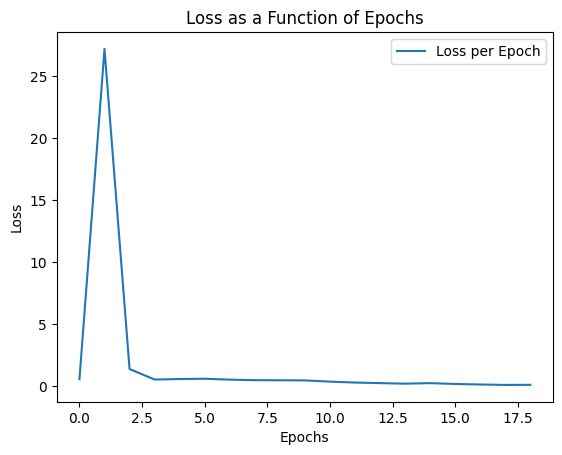

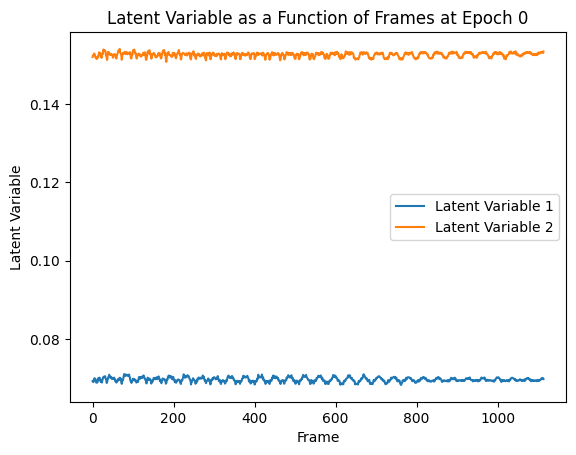

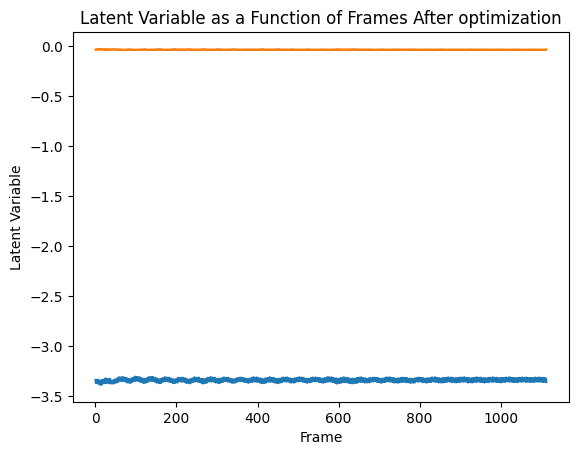

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from data_processing.data_processing2 import images_tensor

class ConvNetAutoencoder_basic(nn.Module):
    def __init__(self, input_shape):
        super(ConvNetAutoencoder_basic, self).__init__()
        self.encoder_conv_layers = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
        )
        # Output Dimension = ((Input dimension +2*padding - kernel_size)/stride) + 1
        # stride is how much we shift after each filter 
        # padding is adding zeros around the edges of your matrix before applying the filter
        # Final dimension is (64,69,25)

        #Dynamically calculate the output shape of the encoder conv layers
        self._get_conv_output(input_shape)

        self.encoder_fc_layers = nn.Sequential(
            nn.Linear(self.num_flat_features, 128),
            nn.ELU(),
            nn.Linear(128, 64),
            nn.ELU(),
            nn.Linear(64, 2),  # Assuming a 2-dimensional latent space
        )

        self.decoder_fc_layers = nn.Sequential(
            nn.Linear(2, 64),
            nn.ELU(),
            nn.Linear(64, 128),
            nn.ELU(),
            nn.Linear(128, self.num_flat_features),
        )

        self.decoder_conv_layers = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
        )
        
    def _get_conv_output(self, shape):
        bs = 1  # Batch size of 1 for testing output shape
        input_tensor = torch.randn(bs, *shape)  # Generate a random tensor without Variable
        with torch.no_grad():  # Disable gradient tracking since this is only for shape calculation
            output_feat = self.encoder_conv_layers(input_tensor)
        self.final_conv_shape = output_feat.shape[1:]  # Store the shape after the last conv layer
        n_size = output_feat.detach().flatten(start_dim=1).size(1)  # Compute flattened size safely
        self.num_flat_features = n_size

    def forward(self, x):
        x = self.encoder_conv_layers(x)
        x = x.view(x.size(0), -1) #Flattening
        x = self.encoder_fc_layers(x)
        latent_vars = x.clone()  # Store latent variables before decoding
        x = self.decoder_fc_layers(x)
        #Use stored shape for dynamic reshaping
        x = x.view(x.size(0), *self.final_conv_shape)
        x = self.decoder_conv_layers(x)
        return x,latent_vars


images_tensor = images_tensor


model = ConvNetAutoencoder_basic(input_shape=(1, 200, 560))
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 30
losses = []
patience = 5
min_delta = 0.01  
latent_epoch_data = []
converged = False


def physics_informed_loss(x, v, lambda_phys=0.3):
    # Example: Assume v should be the derivative of x with respect to some time factor
    # Here we use a simple finite difference approximation (x[n+1] - x[n]) as a placeholder.
    # You can modify this according to the actual physical relation you need to enforce.
    dx_dt_estimated = x[1:] - x[:-1]  # Simple finite difference
    phys_loss = F.mse_loss(v[:-1], dx_dt_estimated)  # MSE between estimated derivative and velocity
    return lambda_phys * phys_loss

for epoch in range(num_epochs):
    if converged:
        break
    model.train()
    optimizer.zero_grad()

    # Forward pass through the model
    reconstructed, latent_vars = model(images_tensor)

    # Standard reconstruction loss
    reconstruction_loss = loss_fn(reconstructed, images_tensor)

    # Extract latent variables assumed as [x, v]
    x, v = latent_vars[:, 0], latent_vars[:, 1]

    # Calculate the physics-informed loss
    phys_loss = physics_informed_loss(x, v)

    # Total loss is the sum of reconstruction loss and physics-informed loss
    total_loss = 0.7*reconstruction_loss + phys_loss

    # Backpropagation
    total_loss.backward()
    optimizer.step()

    losses.append(total_loss.item())
    print(f"Epoch: {epoch}, Total Loss: {total_loss.item():.4f}")

    # Early stopping logic
    if epoch > 0 and (losses[-2] - losses[-1] < min_delta):
        if patience > 0:
            patience -= 1
        else:
            print("Early stopping as the model has converged.")
            converged = True

    if epoch % 50 == 0:
        latent_epoch_data.append(latent_vars.detach().cpu().numpy())



latent_values = []

model.eval()
# Forward pass to get the latent variable
with torch.no_grad():
    xe = model.encoder_conv_layers(images_tensor)
    xe = xe.view(xe.size(0), -1)
    latent_variable = model.encoder_fc_layers(xe)

# Convert the lists to numpy arrays for plotting
latent_values = latent_variable.numpy() 


plt.plot(losses, label='Loss per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss as a Function of Epochs')
plt.legend()
plt.show()


for index, latent_vars_at_epoch in enumerate(latent_epoch_data):
    plt.figure()
    for var_idx in range(latent_vars_at_epoch.shape[1]):  
        plt.plot(latent_vars_at_epoch[:, var_idx], label=f'Latent Variable {var_idx + 1}')
    plt.xlabel('Frame')
    plt.ylabel('Latent Variable')
    plt.title(f'Latent Variable as a Function of Frames at Epoch {index * 50}')
    plt.legend()
    plt.show()



# Plot the latent variable as a function of epochs
plt.plot(latent_values)
plt.xlabel('Frame')
plt.ylabel('Latent Variable')
plt.title('Latent Variable as a Function of Frames After optimization')
plt.show()



Here I added one physics informed loss and I gave it a weight of 0.3 the idea is that our differential equation includes x and v and we know that v is the derivative of x according to time so if one of our latent variables is v it should have a relation as a derivative to the other latent variable which should be x. We still do get oscillations and the values do make more qualitative sense. However our loss updating looks weird I will try to change the coefficient of the physics loss.

Epoch: 0, Total Loss: 0.1447
Epoch: 1, Total Loss: 52.3618
Epoch: 2, Total Loss: 2.7062
Epoch: 3, Total Loss: 0.2453
Epoch: 4, Total Loss: 0.1353
Epoch: 5, Total Loss: 0.2002
Epoch: 6, Total Loss: 0.2308
Epoch: 7, Total Loss: 0.2371
Epoch: 8, Total Loss: 0.4941
Epoch: 9, Total Loss: 0.1869
Epoch: 10, Total Loss: 0.2707
Epoch: 11, Total Loss: 0.1196
Epoch: 12, Total Loss: 0.2060
Epoch: 13, Total Loss: 0.1094
Epoch: 14, Total Loss: 0.1246
Epoch: 15, Total Loss: 0.1280
Epoch: 16, Total Loss: 0.0849
Epoch: 17, Total Loss: 0.1216
Epoch: 18, Total Loss: 0.0737
Epoch: 19, Total Loss: 0.0695
Epoch: 20, Total Loss: 0.0693
Epoch: 21, Total Loss: 0.0521
Epoch: 22, Total Loss: 0.0616
Epoch: 23, Total Loss: 0.0387
Epoch: 24, Total Loss: 0.0405
Epoch: 25, Total Loss: 0.0314
Epoch: 26, Total Loss: 0.0260
Epoch: 27, Total Loss: 0.0311
Epoch: 28, Total Loss: 0.0176
Epoch: 29, Total Loss: 0.0216


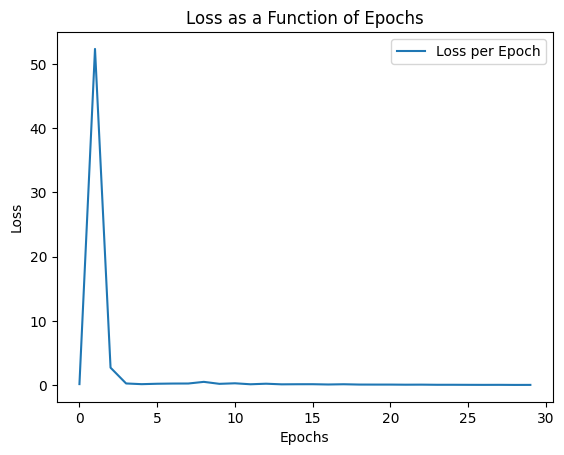

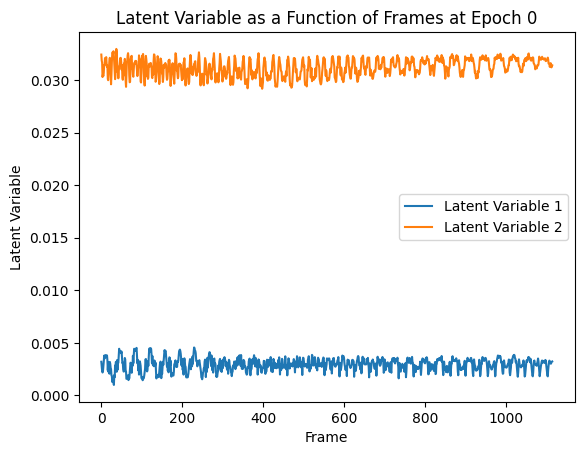

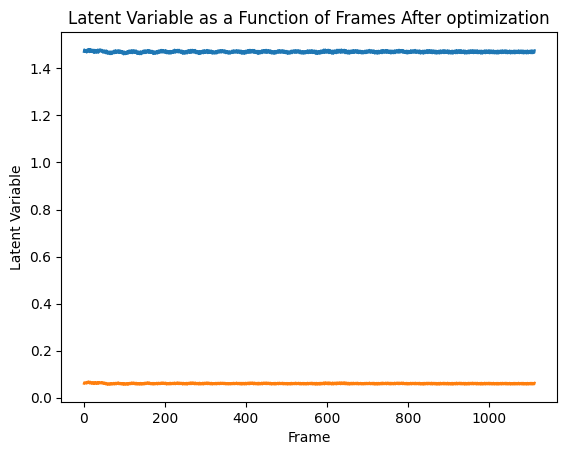

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from data_processing.data_processing2 import images_tensor

class ConvNetAutoencoder_basic(nn.Module):
    def __init__(self, input_shape):
        super(ConvNetAutoencoder_basic, self).__init__()
        self.encoder_conv_layers = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
        )
        # Output Dimension = ((Input dimension +2*padding - kernel_size)/stride) + 1
        # stride is how much we shift after each filter 
        # padding is adding zeros around the edges of your matrix before applying the filter
        # Final dimension is (64,69,25)

        #Dynamically calculate the output shape of the encoder conv layers
        self._get_conv_output(input_shape)

        self.encoder_fc_layers = nn.Sequential(
            nn.Linear(self.num_flat_features, 128),
            nn.ELU(),
            nn.Linear(128, 64),
            nn.ELU(),
            nn.Linear(64, 2),  # Assuming a 2-dimensional latent space
        )

        self.decoder_fc_layers = nn.Sequential(
            nn.Linear(2, 64),
            nn.ELU(),
            nn.Linear(64, 128),
            nn.ELU(),
            nn.Linear(128, self.num_flat_features),
        )

        self.decoder_conv_layers = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
        )
        
    def _get_conv_output(self, shape):
        bs = 1  # Batch size of 1 for testing output shape
        input_tensor = torch.randn(bs, *shape)  # Generate a random tensor without Variable
        with torch.no_grad():  # Disable gradient tracking since this is only for shape calculation
            output_feat = self.encoder_conv_layers(input_tensor)
        self.final_conv_shape = output_feat.shape[1:]  # Store the shape after the last conv layer
        n_size = output_feat.detach().flatten(start_dim=1).size(1)  # Compute flattened size safely
        self.num_flat_features = n_size

    def forward(self, x):
        x = self.encoder_conv_layers(x)
        x = x.view(x.size(0), -1) #Flattening
        x = self.encoder_fc_layers(x)
        latent_vars = x.clone()  # Store latent variables before decoding
        x = self.decoder_fc_layers(x)
        #Use stored shape for dynamic reshaping
        x = x.view(x.size(0), *self.final_conv_shape)
        x = self.decoder_conv_layers(x)
        return x,latent_vars


images_tensor = images_tensor


model = ConvNetAutoencoder_basic(input_shape=(1, 200, 560))
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 30
losses = []
patience = 20
min_delta = 0.01  
latent_epoch_data = []
converged = False


def physics_informed_loss(x, v, lambda_phys=0.5):
    # Example: Assume v should be the derivative of x with respect to some time factor
    # Here we use a simple finite difference approximation (x[n+1] - x[n]) as a placeholder.
    # You can modify this according to the actual physical relation you need to enforce.
    dx_dt_estimated = x[1:] - x[:-1]  # Simple finite difference
    phys_loss = F.mse_loss(v[:-1], dx_dt_estimated)  # MSE between estimated derivative and velocity
    return lambda_phys * phys_loss

for epoch in range(num_epochs):
    if converged:
        break
    model.train()
    optimizer.zero_grad()

    # Forward pass through the model
    reconstructed, latent_vars = model(images_tensor)

    # Standard reconstruction loss
    reconstruction_loss = loss_fn(reconstructed, images_tensor)

    # Extract latent variables assumed as [x, v]
    x, v = latent_vars[:, 0], latent_vars[:, 1]

    # Calculate the physics-informed loss
    phys_loss = physics_informed_loss(x, v)

    # Total loss is the sum of reconstruction loss and physics-informed loss
    total_loss = 0.5*reconstruction_loss + phys_loss

    # Backpropagation
    total_loss.backward()
    optimizer.step()

    losses.append(total_loss.item())
    print(f"Epoch: {epoch}, Total Loss: {total_loss.item():.4f}")

    # Early stopping logic
    if epoch > 0 and (losses[-2] - losses[-1] < min_delta):
        if patience > 0:
            patience -= 1
        else:
            print("Early stopping as the model has converged.")
            converged = True

    if epoch % 50 == 0:
        latent_epoch_data.append(latent_vars.detach().cpu().numpy())



latent_values = []

model.eval()
# Forward pass to get the latent variable
with torch.no_grad():
    xe = model.encoder_conv_layers(images_tensor)
    xe = xe.view(xe.size(0), -1)
    latent_variable = model.encoder_fc_layers(xe)

# Convert the lists to numpy arrays for plotting
latent_values = latent_variable.numpy() 


plt.plot(losses, label='Loss per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss as a Function of Epochs')
plt.legend()
plt.show()


for index, latent_vars_at_epoch in enumerate(latent_epoch_data):
    plt.figure()
    for var_idx in range(latent_vars_at_epoch.shape[1]):  
        plt.plot(latent_vars_at_epoch[:, var_idx], label=f'Latent Variable {var_idx + 1}')
    plt.xlabel('Frame')
    plt.ylabel('Latent Variable')
    plt.title(f'Latent Variable as a Function of Frames at Epoch {index * 50}')
    plt.legend()
    plt.show()



# Plot the latent variable as a function of epochs
plt.plot(latent_values)
plt.xlabel('Frame')
plt.ylabel('Latent Variable')
plt.title('Latent Variable as a Function of Frames After optimization')
plt.show()



Expected Shape: [num_frames, 1, 200, 560]
Actual Shape: torch.Size([1114, 1, 200, 560])
Epoch: 0, Total Loss: 0.2867
Epoch: 1, Total Loss: 36.3196
Epoch: 2, Total Loss: 0.6525
Epoch: 3, Total Loss: 0.3491
Epoch: 4, Total Loss: 0.3892
Epoch: 5, Total Loss: 0.3222
Epoch: 6, Total Loss: 0.2384
Epoch: 7, Total Loss: 0.3591
Epoch: 8, Total Loss: 0.6214
Epoch: 9, Total Loss: 0.3633
Epoch: 10, Total Loss: 0.1495
Epoch: 11, Total Loss: 0.2122
Epoch: 12, Total Loss: 0.2224
Epoch: 13, Total Loss: 0.1590
Epoch: 14, Total Loss: 0.1005
Epoch: 15, Total Loss: 0.0794
Epoch: 16, Total Loss: 0.0796
Epoch: 17, Total Loss: 0.0848
Epoch: 18, Total Loss: 0.0820
Epoch: 19, Total Loss: 0.0692
Epoch: 20, Total Loss: 0.0535
Epoch: 21, Total Loss: 0.0430
Epoch: 22, Total Loss: 0.0412
Epoch: 23, Total Loss: 0.0444
Epoch: 24, Total Loss: 0.0453
Epoch: 25, Total Loss: 0.0401
Epoch: 26, Total Loss: 0.0310
Epoch: 27, Total Loss: 0.0227
Epoch: 28, Total Loss: 0.0186
Epoch: 29, Total Loss: 0.0186


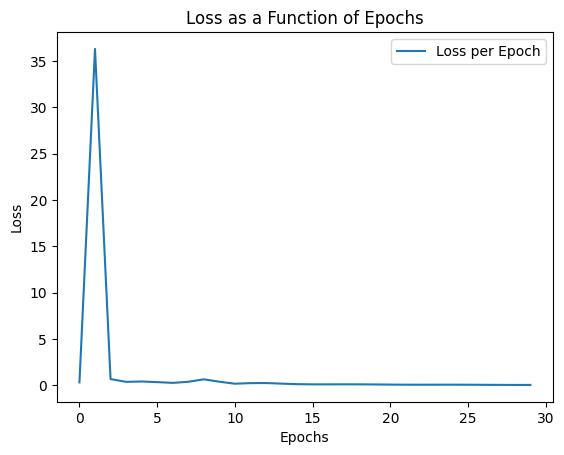

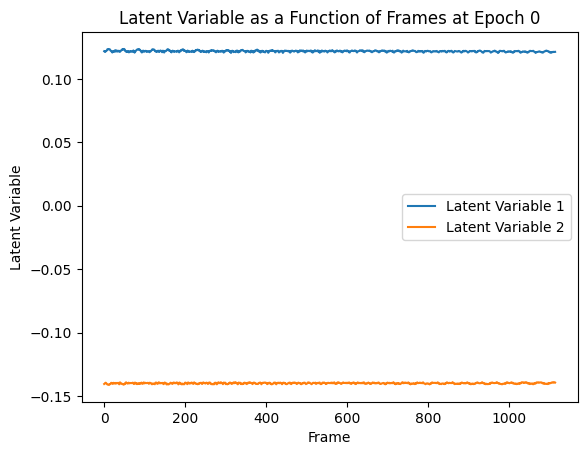

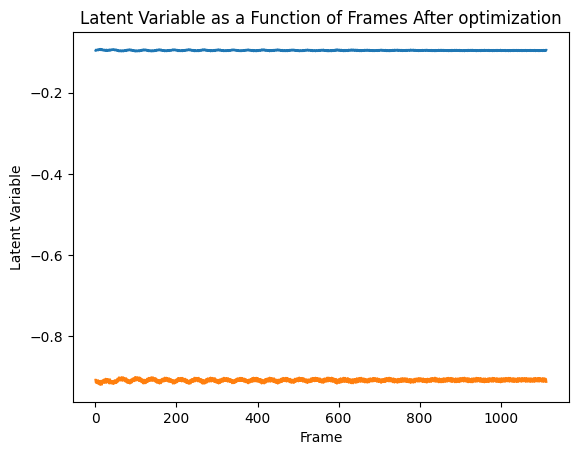

In [3]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from data_processing.data_processing2 import images_tensor

class ConvNetAutoencoder_basic(nn.Module):
    def __init__(self, input_shape):
        super(ConvNetAutoencoder_basic, self).__init__()
        self.encoder_conv_layers = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
        )
        # Output Dimension = ((Input dimension +2*padding - kernel_size)/stride) + 1
        # stride is how much we shift after each filter 
        # padding is adding zeros around the edges of your matrix before applying the filter
        # Final dimension is (64,69,25)

        #Dynamically calculate the output shape of the encoder conv layers
        self._get_conv_output(input_shape)

        self.encoder_fc_layers = nn.Sequential(
            nn.Linear(self.num_flat_features, 128),
            nn.ELU(),
            nn.Linear(128, 64),
            nn.ELU(),
            nn.Linear(64, 2),  # Assuming a 2-dimensional latent space
        )

        self.decoder_fc_layers = nn.Sequential(
            nn.Linear(2, 64),
            nn.ELU(),
            nn.Linear(64, 128),
            nn.ELU(),
            nn.Linear(128, self.num_flat_features),
        )

        self.decoder_conv_layers = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
        )
        
    def _get_conv_output(self, shape):
        bs = 1  # Batch size of 1 for testing output shape
        input_tensor = torch.randn(bs, *shape)  # Generate a random tensor without Variable
        with torch.no_grad():  # Disable gradient tracking since this is only for shape calculation
            output_feat = self.encoder_conv_layers(input_tensor)
        self.final_conv_shape = output_feat.shape[1:]  # Store the shape after the last conv layer
        n_size = output_feat.detach().flatten(start_dim=1).size(1)  # Compute flattened size safely
        self.num_flat_features = n_size

    def forward(self, x):
        x = self.encoder_conv_layers(x)
        x = x.view(x.size(0), -1) #Flattening
        x = self.encoder_fc_layers(x)
        latent_vars = x.clone()  # Store latent variables before decoding
        x = self.decoder_fc_layers(x)
        #Use stored shape for dynamic reshaping
        x = x.view(x.size(0), *self.final_conv_shape)
        x = self.decoder_conv_layers(x)
        return x,latent_vars


images_tensor = images_tensor


model = ConvNetAutoencoder_basic(input_shape=(1, 200, 560))
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 30
losses = []
patience = 20
min_delta = 0.01  
latent_epoch_data = []
converged = False


def physics_informed_loss(x, v, lambda_phys=0.5):
    # Example: Assume v should be the derivative of x with respect to some time factor
    # Here we use a simple finite difference approximation (x[n+1] - x[n]) as a placeholder.
    # You can modify this according to the actual physical relation you need to enforce.
    dx_dt_estimated = x[1:] - x[:-1]  # Simple finite difference
    phys_loss = F.mse_loss(v[:-1], dx_dt_estimated)  # MSE between estimated derivative and velocity
    return lambda_phys * phys_loss

for epoch in range(num_epochs):
    if converged:
        break
    model.train()
    optimizer.zero_grad()

    # Forward pass through the model
    reconstructed, latent_vars = model(images_tensor)

    # Standard reconstruction loss
    reconstruction_loss = loss_fn(reconstructed, images_tensor)

    # Extract latent variables assumed as [x, v]
    v, x = latent_vars[:, 0], latent_vars[:, 1]

    # Calculate the physics-informed loss
    phys_loss = physics_informed_loss(x, v)

    # Total loss is the sum of reconstruction loss and physics-informed loss
    total_loss = 0.5*reconstruction_loss + phys_loss

    # Backpropagation
    total_loss.backward()
    optimizer.step()

    losses.append(total_loss.item())
    print(f"Epoch: {epoch}, Total Loss: {total_loss.item():.4f}")

    # Early stopping logic
    if epoch > 0 and (losses[-2] - losses[-1] < min_delta):
        if patience > 0:
            patience -= 1
        else:
            print("Early stopping as the model has converged.")
            converged = True

    if epoch % 50 == 0:
        latent_epoch_data.append(latent_vars.detach().cpu().numpy())



latent_values = []

model.eval()
# Forward pass to get the latent variable
with torch.no_grad():
    xe = model.encoder_conv_layers(images_tensor)
    xe = xe.view(xe.size(0), -1)
    latent_variable = model.encoder_fc_layers(xe)

# Convert the lists to numpy arrays for plotting
latent_values = latent_variable.numpy() 


plt.plot(losses, label='Loss per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss as a Function of Epochs')
plt.legend()
plt.show()


for index, latent_vars_at_epoch in enumerate(latent_epoch_data):
    plt.figure()
    for var_idx in range(latent_vars_at_epoch.shape[1]):  
        plt.plot(latent_vars_at_epoch[:, var_idx], label=f'Latent Variable {var_idx + 1}')
    plt.xlabel('Frame')
    plt.ylabel('Latent Variable')
    plt.title(f'Latent Variable as a Function of Frames at Epoch {index * 50}')
    plt.legend()
    plt.show()



# Plot the latent variable as a function of epochs
plt.plot(latent_values)
plt.xlabel('Frame')
plt.ylabel('Latent Variable')
plt.title('Latent Variable as a Function of Frames After optimization')
plt.show()



Here I am flipping the latent variables

before we try adding another physics loss i will try reducing the learning rate

Epoch: 0, Total Loss: 0.2259
Epoch: 1, Total Loss: 1.1805
Epoch: 2, Total Loss: 0.3286
Epoch: 3, Total Loss: 0.3607
Epoch: 4, Total Loss: 0.4855
Epoch: 5, Total Loss: 0.3975
Epoch: 6, Total Loss: 0.2823
Epoch: 7, Total Loss: 0.2253
Epoch: 8, Total Loss: 0.2262
Epoch: 9, Total Loss: 0.2512
Epoch: 10, Total Loss: 0.2719
Epoch: 11, Total Loss: 0.2763
Epoch: 12, Total Loss: 0.2666
Epoch: 13, Total Loss: 0.2502
Epoch: 14, Total Loss: 0.2343
Epoch: 15, Total Loss: 0.2229
Epoch: 16, Total Loss: 0.2177
Epoch: 17, Total Loss: 0.2177
Epoch: 18, Total Loss: 0.2209
Epoch: 19, Total Loss: 0.2249
Epoch: 20, Total Loss: 0.2280
Epoch: 21, Total Loss: 0.2292
Epoch: 22, Total Loss: 0.2283
Epoch: 23, Total Loss: 0.2257
Epoch: 24, Total Loss: 0.2221
Epoch: 25, Total Loss: 0.2184
Epoch: 26, Total Loss: 0.2151
Epoch: 27, Total Loss: 0.2127
Epoch: 28, Total Loss: 0.2113
Early stopping as the model has converged.


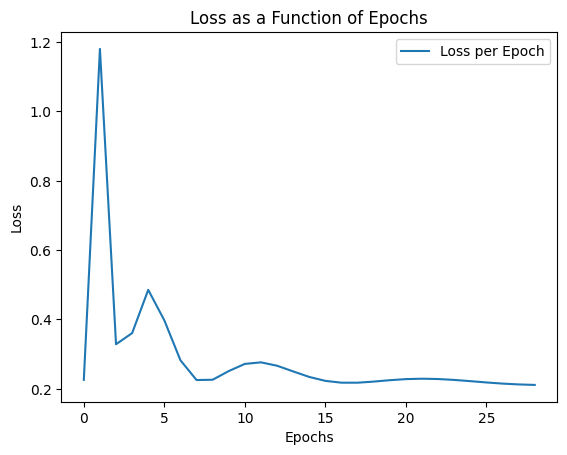

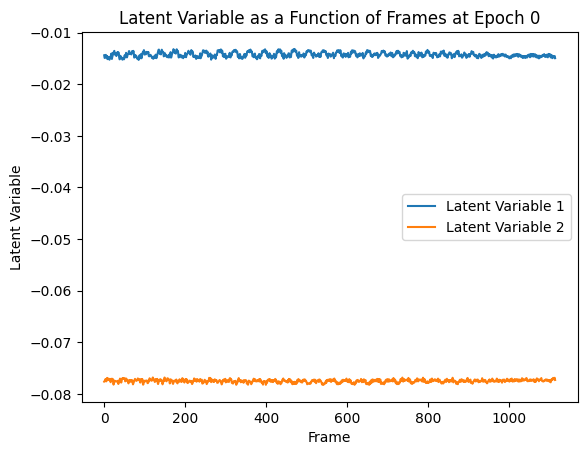

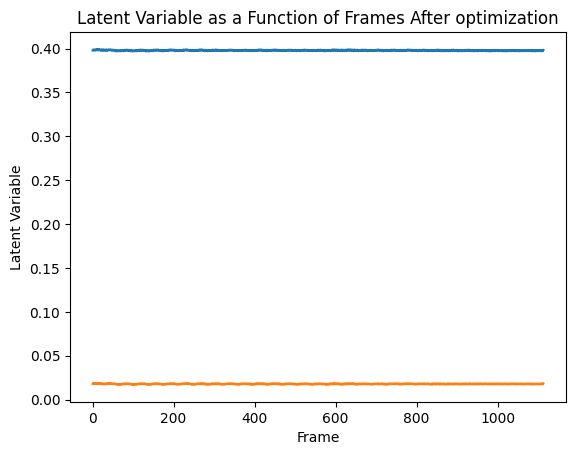

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from data_processing.data_processing2 import images_tensor

class ConvNetAutoencoder_basic(nn.Module):
    def __init__(self, input_shape):
        super(ConvNetAutoencoder_basic, self).__init__()
        self.encoder_conv_layers = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
        )
        # Output Dimension = ((Input dimension +2*padding - kernel_size)/stride) + 1
        # stride is how much we shift after each filter 
        # padding is adding zeros around the edges of your matrix before applying the filter
        # Final dimension is (64,69,25)

        #Dynamically calculate the output shape of the encoder conv layers
        self._get_conv_output(input_shape)

        self.encoder_fc_layers = nn.Sequential(
            nn.Linear(self.num_flat_features, 128),
            nn.ELU(),
            nn.Linear(128, 64),
            nn.ELU(),
            nn.Linear(64, 2),  # Assuming a 2-dimensional latent space
        )

        self.decoder_fc_layers = nn.Sequential(
            nn.Linear(2, 64),
            nn.ELU(),
            nn.Linear(64, 128),
            nn.ELU(),
            nn.Linear(128, self.num_flat_features),
        )

        self.decoder_conv_layers = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
        )
        
    def _get_conv_output(self, shape):
        bs = 1  # Batch size of 1 for testing output shape
        input_tensor = torch.randn(bs, *shape)  # Generate a random tensor without Variable
        with torch.no_grad():  # Disable gradient tracking since this is only for shape calculation
            output_feat = self.encoder_conv_layers(input_tensor)
        self.final_conv_shape = output_feat.shape[1:]  # Store the shape after the last conv layer
        n_size = output_feat.detach().flatten(start_dim=1).size(1)  # Compute flattened size safely
        self.num_flat_features = n_size

    def forward(self, x):
        x = self.encoder_conv_layers(x)
        x = x.view(x.size(0), -1) #Flattening
        x = self.encoder_fc_layers(x)
        latent_vars = x.clone()  # Store latent variables before decoding
        x = self.decoder_fc_layers(x)
        #Use stored shape for dynamic reshaping
        x = x.view(x.size(0), *self.final_conv_shape)
        x = self.decoder_conv_layers(x)
        return x,latent_vars


images_tensor = images_tensor


model = ConvNetAutoencoder_basic(input_shape=(1, 200, 560))
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
num_epochs = 30
losses = []
patience = 20
min_delta = 0.01  
latent_epoch_data = []
converged = False


def physics_informed_loss(x, v, lambda_phys=0.5):
    dx_dt_estimated = x[1:] - x[:-1]  # Simple finite difference
    phys_loss = F.mse_loss(v[:-1], dx_dt_estimated)  # MSE between estimated derivative and velocity
    return lambda_phys * phys_loss

for epoch in range(num_epochs):
    if converged:
        break
    model.train()
    optimizer.zero_grad()

    # Forward pass through the model
    reconstructed, latent_vars = model(images_tensor)

    # Standard reconstruction loss
    reconstruction_loss = loss_fn(reconstructed, images_tensor)

    # Extract latent variables assumed as [x, v]
    x, v = latent_vars[:, 0], latent_vars[:, 1]

    # Calculate the physics-informed loss
    phys_loss = physics_informed_loss(x, v)

    # Total loss is the sum of reconstruction loss and physics-informed loss
    total_loss = 0.5*reconstruction_loss + phys_loss

    # Backpropagation
    total_loss.backward()
    optimizer.step()

    losses.append(total_loss.item())
    print(f"Epoch: {epoch}, Total Loss: {total_loss.item():.4f}")

    # Early stopping logic
    if epoch > 0 and (losses[-2] - losses[-1] < min_delta):
        if patience > 0:
            patience -= 1
        else:
            print("Early stopping as the model has converged.")
            converged = True

    if epoch % 50 == 0:
        latent_epoch_data.append(latent_vars.detach().cpu().numpy())



latent_values = []

model.eval()
# Forward pass to get the latent variable
with torch.no_grad():
    xe = model.encoder_conv_layers(images_tensor)
    xe = xe.view(xe.size(0), -1)
    latent_variable = model.encoder_fc_layers(xe)

# Convert the lists to numpy arrays for plotting
latent_values = latent_variable.numpy() 


plt.plot(losses, label='Loss per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss as a Function of Epochs')
plt.legend()
plt.show()


for index, latent_vars_at_epoch in enumerate(latent_epoch_data):
    plt.figure()
    for var_idx in range(latent_vars_at_epoch.shape[1]):  
        plt.plot(latent_vars_at_epoch[:, var_idx], label=f'Latent Variable {var_idx + 1}')
    plt.xlabel('Frame')
    plt.ylabel('Latent Variable')
    plt.title(f'Latent Variable as a Function of Frames at Epoch {index * 50}')
    plt.legend()
    plt.show()



# Plot the latent variable as a function of epochs
plt.plot(latent_values)
plt.xlabel('Frame')
plt.ylabel('Latent Variable')
plt.title('Latent Variable as a Function of Frames After optimization')
plt.show()



This did worse so now let us try to find the actual v and x of the system using data processing and add physics informed losses using actual values

2025-04-16 18:01:28.880 Python[948:8507] +[IMKClient subclass]: chose IMKClient_Modern
2025-04-16 18:01:28.880 Python[948:8507] +[IMKInputSession subclass]: chose IMKInputSession_Modern


Reference point selected at: (401, 83)
Select a ROI and then press SPACE or ENTER button!
Cancel the selection process by pressing c button!
Measured rod length in pixels: 45.49


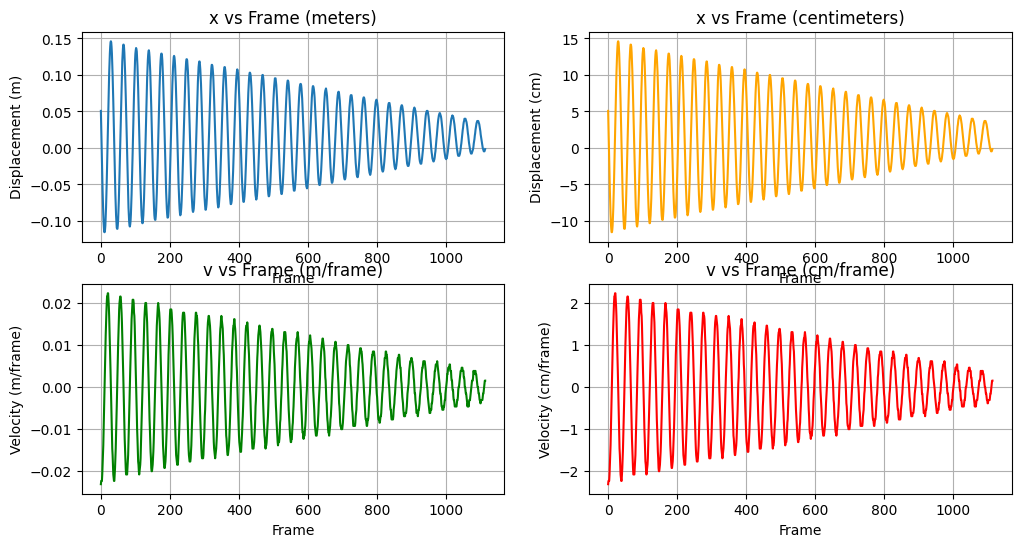

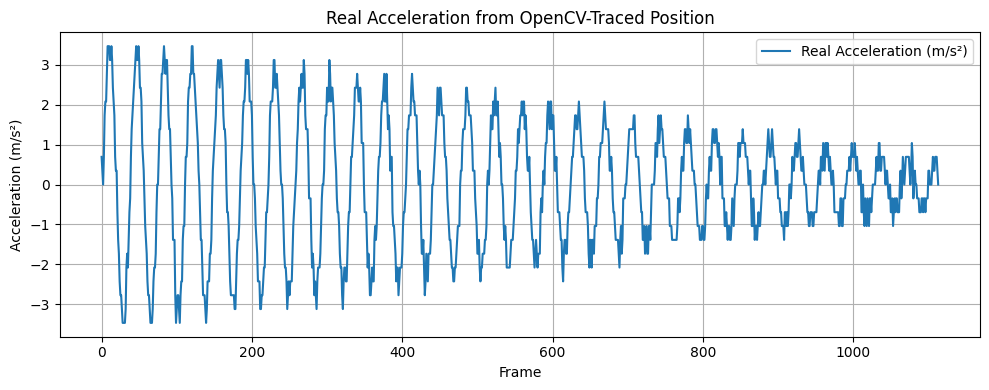

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

video_path = '/Users/karim/desktop/eece499/spring-osc-trim.mov'



cap = cv2.VideoCapture(video_path)
ret, frame = cap.read()
if not ret:
    raise ValueError("Failed to read first frame.")

ref_point = []

def select_reference(event, x, y, flags, param):
    if event == cv2.EVENT_LBUTTONDOWN:
        ref_point.clear()
        ref_point.append((x, y))
        print(f"Reference point selected at: ({x}, {y})")
        cv2.circle(frame, (x, y), 5, (0, 255, 0), -1)
        cv2.imshow("Select Reference", frame)

cv2.imshow("Select Reference", frame)
cv2.setMouseCallback("Select Reference", select_reference)
cv2.waitKey(0)
cv2.destroyAllWindows()

if not ref_point:
    raise ValueError("No reference point selected.")
ref_x = ref_point[0][0]
ref_y = ref_point[0][1]


roi = cv2.selectROI("Select Rod Template", frame, fromCenter=False, showCrosshair=True)
cv2.destroyAllWindows()
x, y, w, h = map(int, roi)
template = frame[y:y+h, x:x+w]
template_gray = cv2.cvtColor(template, cv2.COLOR_BGR2GRAY)

ret, frame = cap.read()
points = []

def click_ends(event, x, y, flags, param):
    if event == cv2.EVENT_LBUTTONDOWN:
        points.append((x, y))
        cv2.circle(frame, (x, y), 5, (255, 0, 0), -1)
        cv2.imshow("Click Ends of Rod (for scale)", frame)

cv2.imshow("Click Ends of Rod (for scale)", frame)
cv2.setMouseCallback("Click Ends of Rod (for scale)", click_ends)
cv2.waitKey(0)
cv2.destroyAllWindows()

if len(points) != 2:
    raise ValueError("You must click exactly two points on the rod.")
rod_px_length = np.linalg.norm(np.array(points[0]) - np.array(points[1]))
print(f"Measured rod length in pixels: {rod_px_length:.2f}")


real_rod_cm = 7
scale_cm = real_rod_cm / rod_px_length
scale_m = scale_cm / 100


cap = cv2.VideoCapture(video_path)
fps = cap.get(cv2.CAP_PROP_FPS)
dt = 1.0 / fps

positions = []
times = []
frame_idx = 0

while True:
    ret, frame = cap.read()
    if not ret:
        break

    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    result = cv2.matchTemplate(gray, template_gray, cv2.TM_CCOEFF_NORMED)
    _, _, _, max_loc = cv2.minMaxLoc(result)
    top_left = max_loc
    center_x = top_left[0] + w // 2
    center_y = top_left[1] + h // 2

    displacement_px = center_x - ref_x
    positions.append(displacement_px)
    times.append(frame_idx * dt)

    # Show tracking (optional)
    cv2.circle(frame, (center_x, center_y), 5, (0, 0, 255), -1)
    cv2.circle(frame, (ref_x, ref_y), 5, (0, 255, 0), -1)
    cv2.putText(frame, f"x: {displacement_px}px", (center_x + 10, center_y),
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1)
    cv2.imshow("Rod Tracking", frame)

    if cv2.waitKey(int(1000 / fps)) & 0xFF == ord('q'):
        break

    frame_idx += 1


cap.release()
cv2.destroyAllWindows()
for _ in range(5):  # Give the system time to flush GUI events
    cv2.waitKey(1)


positions = np.array(positions)
positions_m = positions * scale_m
positions_cm = positions * scale_cm

vel_m_per_frame = np.gradient(positions_m)
vel_cm_per_frame = np.gradient(positions_cm)

frame_indices = np.arange(len(positions))

# First compute velocity from position
velocity_m = np.gradient(positions_m, dt)

# Then compute acceleration from velocity (second derivative of position)
acceleration_m = np.gradient(velocity_m, dt)


plt.figure(figsize=(12, 6))

plt.subplot(2, 2, 1)
plt.plot(frame_indices, positions_m)
plt.title("x vs Frame (meters)")
plt.xlabel("Frame")
plt.ylabel("Displacement (m)")
plt.grid(True)

plt.subplot(2, 2, 2)
plt.plot(frame_indices, positions_cm, color='orange')
plt.title("x vs Frame (centimeters)")
plt.xlabel("Frame")
plt.ylabel("Displacement (cm)")
plt.grid(True)

plt.subplot(2, 2, 3)
plt.plot(frame_indices, vel_m_per_frame, color='green')
plt.title("v vs Frame (m/frame)")
plt.xlabel("Frame")
plt.ylabel("Velocity (m/frame)")
plt.grid(True)

plt.subplot(2, 2, 4)
plt.plot(frame_indices, vel_cm_per_frame, color='red')
plt.title("v vs Frame (cm/frame)")
plt.xlabel("Frame")
plt.ylabel("Velocity (cm/frame)")
plt.grid(True)


# Plot acceleration
plt.figure(figsize=(10, 4))
plt.plot(acceleration_m, label='Real Acceleration (m/s²)')
plt.xlabel('Frame')
plt.ylabel('Acceleration (m/s²)')
plt.title('Real Acceleration from OpenCV-Traced Position')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


Epoch: 0, Total Loss: 0.5270
Epoch: 1, Total Loss: 50.9602
Epoch: 2, Total Loss: 2.1659
Epoch: 3, Total Loss: 0.5105
Epoch: 4, Total Loss: 0.5767
Epoch: 5, Total Loss: 0.5946
Epoch: 6, Total Loss: 0.5431
Epoch: 7, Total Loss: 2.3204
Epoch: 8, Total Loss: 0.4996
Epoch: 9, Total Loss: 1.2174
Epoch: 10, Total Loss: 0.6040
Epoch: 11, Total Loss: 0.4962
Epoch: 12, Total Loss: 0.6529
Epoch: 13, Total Loss: 0.4681
Epoch: 14, Total Loss: 0.3244
Epoch: 15, Total Loss: 0.4049
Epoch: 16, Total Loss: 0.4001
Epoch: 17, Total Loss: 0.2854
Epoch: 18, Total Loss: 0.2392
Epoch: 19, Total Loss: 0.2671
Epoch: 20, Total Loss: 0.2611
Epoch: 21, Total Loss: 0.1966
Epoch: 22, Total Loss: 0.1428
Epoch: 23, Total Loss: 0.1344
Epoch: 24, Total Loss: 0.1464
Epoch: 25, Total Loss: 0.1408
Epoch: 26, Total Loss: 0.1124
Epoch: 27, Total Loss: 0.0840
Epoch: 28, Total Loss: 0.0741
Epoch: 29, Total Loss: 0.0769


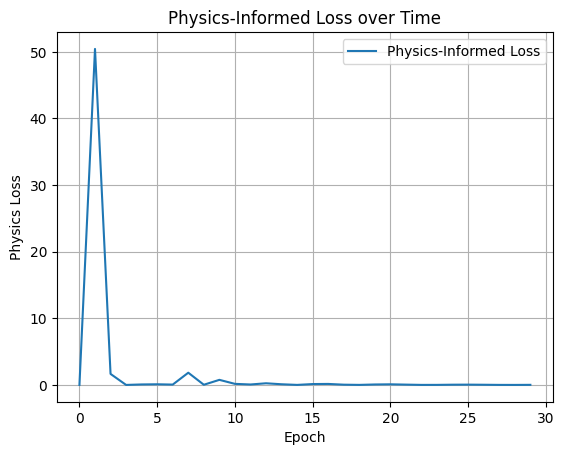

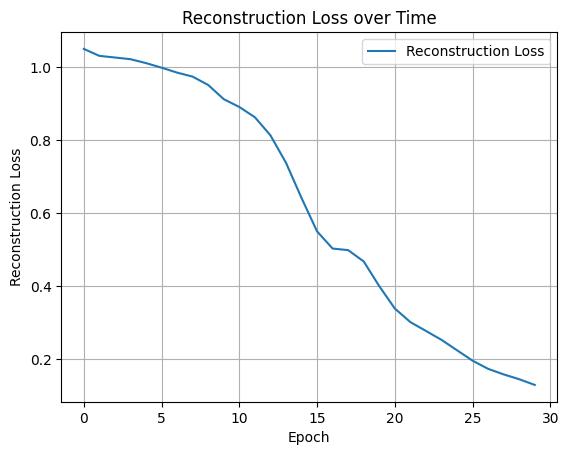

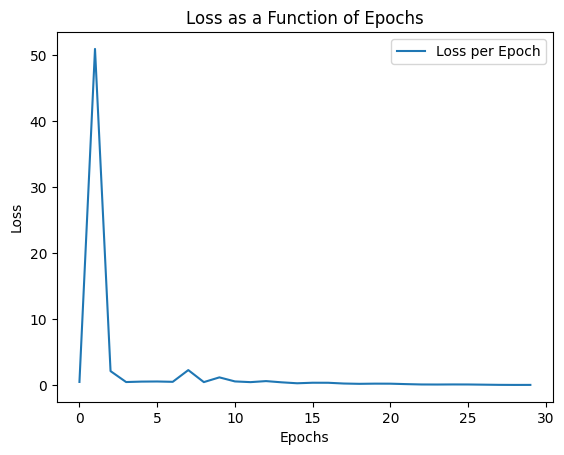

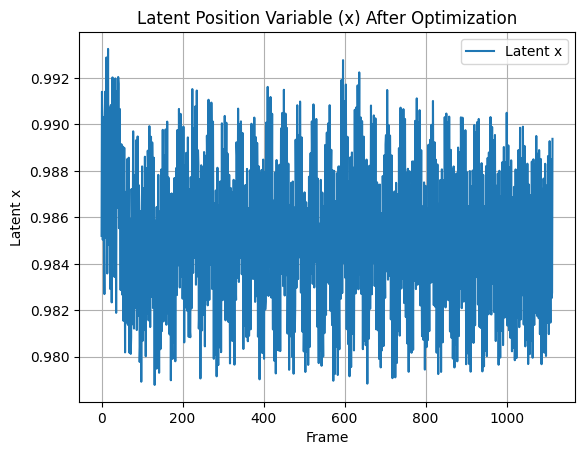

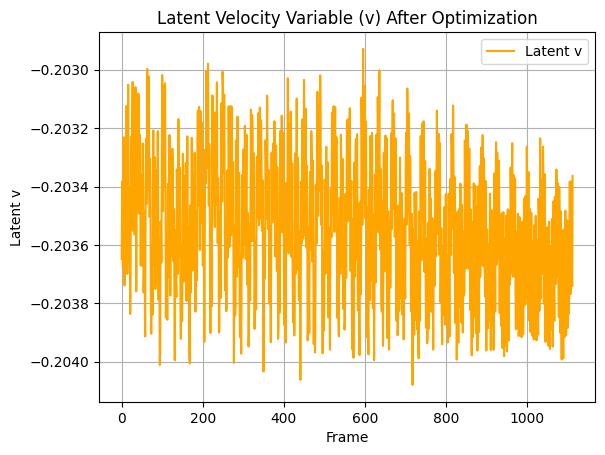

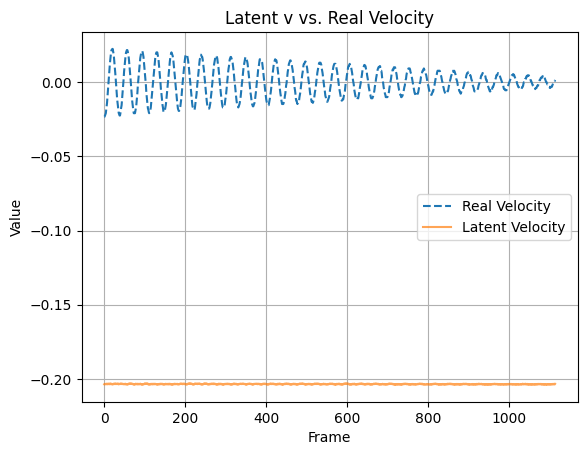

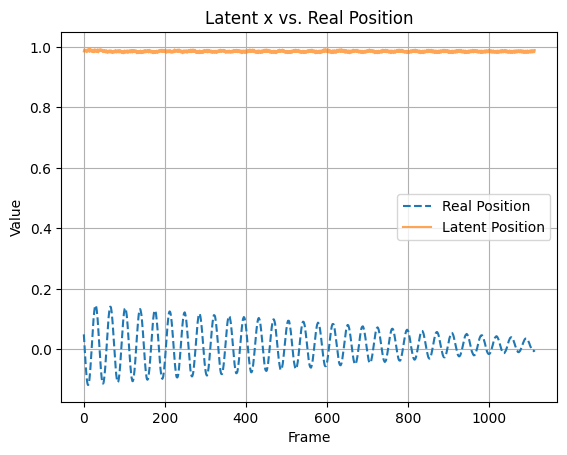

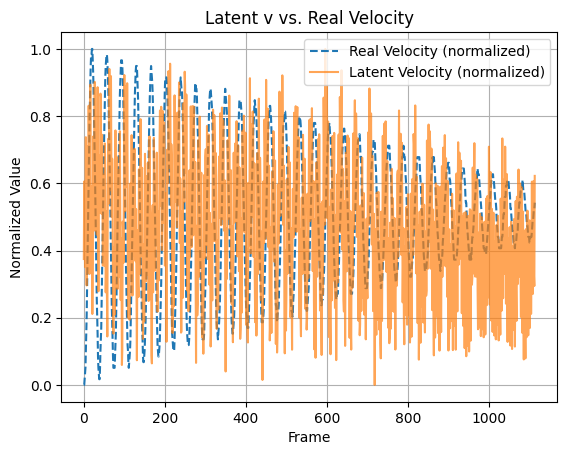

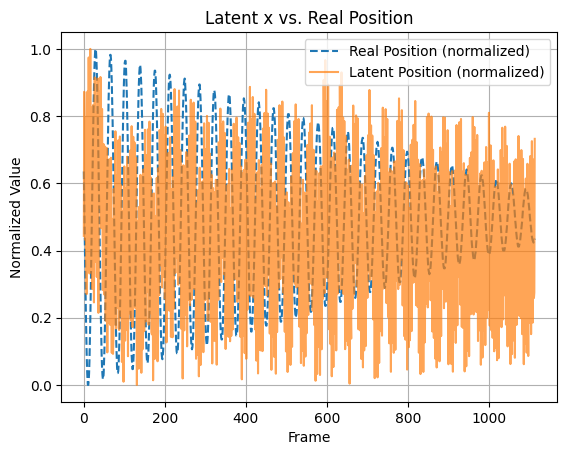

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from data_processing.data_processing2 import images_tensor

class ConvNetAutoencoder_basic(nn.Module):
    def __init__(self, input_shape):
        super(ConvNetAutoencoder_basic, self).__init__()
        self.encoder_conv_layers = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
        )
        # Output Dimension = ((Input dimension +2*padding - kernel_size)/stride) + 1
        # stride is how much we shift after each filter 
        # padding is adding zeros around the edges of your matrix before applying the filter
        # Final dimension is (64,69,25)

        #Dynamically calculate the output shape of the encoder conv layers
        self._get_conv_output(input_shape)

        self.encoder_fc_layers = nn.Sequential(
            nn.Linear(self.num_flat_features, 128),
            nn.ELU(),
            nn.Linear(128, 64),
            nn.ELU(),
            nn.Linear(64, 2),  # Assuming a 2-dimensional latent space
        )

        self.decoder_fc_layers = nn.Sequential(
            nn.Linear(2, 64),
            nn.ELU(),
            nn.Linear(64, 128),
            nn.ELU(),
            nn.Linear(128, self.num_flat_features),
        )

        self.decoder_conv_layers = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
        )
        
    def _get_conv_output(self, shape):
        bs = 1  # Batch size of 1 for testing output shape
        input_tensor = torch.randn(bs, *shape)  # Generate a random tensor without Variable
        with torch.no_grad():  # Disable gradient tracking since this is only for shape calculation
            output_feat = self.encoder_conv_layers(input_tensor)
        self.final_conv_shape = output_feat.shape[1:]  # Store the shape after the last conv layer
        n_size = output_feat.detach().flatten(start_dim=1).size(1)  # Compute flattened size safely
        self.num_flat_features = n_size

    def forward(self, x):
        x = self.encoder_conv_layers(x)
        x = x.view(x.size(0), -1) #Flattening
        x = self.encoder_fc_layers(x)
        latent_vars = x.clone()  # Store latent variables before decoding
        x = self.decoder_fc_layers(x)
        #Use stored shape for dynamic reshaping
        x = x.view(x.size(0), *self.final_conv_shape)
        x = self.decoder_conv_layers(x)
        return x,latent_vars


images_tensor = images_tensor


model = ConvNetAutoencoder_basic(input_shape=(1, 200, 560))
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 30
losses = []
patience = 20
min_delta = 0.01  
latent_epoch_data = []
converged = False
phys_losses = []
reconstruction_losses = []


def physics_informed_loss(x, v, lambda_phys=0.5):
    dx_dt_estimated = x[1:] - x[:-1]  # Simple finite difference
    phys_loss = F.mse_loss(v[:-1], dx_dt_estimated)  # MSE between estimated derivative and velocity
    return lambda_phys * phys_loss

for epoch in range(num_epochs):
    if converged:
        break
    model.train()
    optimizer.zero_grad()

    # Forward pass through the model
    reconstructed, latent_vars = model(images_tensor)

    # Standard reconstruction loss
    reconstruction_loss = loss_fn(reconstructed, images_tensor)

    # Extract latent variables assumed as [x, v]
    x, v = latent_vars[:, 0], latent_vars[:, 1]

    # Calculate the physics-informed loss
    phys_loss = physics_informed_loss(x, v)

    # Total loss is the sum of reconstruction loss and physics-informed loss
    total_loss = 0.5*reconstruction_loss + phys_loss

    # Backpropagation
    total_loss.backward()
    optimizer.step()

    phys_losses.append(phys_loss.item())
    reconstruction_losses.append(reconstruction_loss.item())
    losses.append(total_loss.item())
    print(f"Epoch: {epoch}, Total Loss: {total_loss.item():.4f}")

    # Early stopping logic
    if epoch > 0 and (losses[-2] - losses[-1] < min_delta):
        if patience > 0:
            patience -= 1
        else:
            print("Early stopping as the model has converged.")
            converged = True

    if epoch % 50 == 0:
        latent_epoch_data.append(latent_vars.detach().cpu().numpy())



latent_values = []

model.eval()
# Forward pass to get the latent variable
with torch.no_grad():
    xe = model.encoder_conv_layers(images_tensor)
    xe = xe.view(xe.size(0), -1)
    latent_variable = model.encoder_fc_layers(xe)

# Convert the lists to numpy arrays for plotting
latent_values = latent_variable.numpy() 


plt.plot(phys_losses, label='Physics-Informed Loss')
plt.xlabel('Epoch')
plt.ylabel('Physics Loss')
plt.title('Physics-Informed Loss over Time')
plt.grid(True)
plt.legend()
plt.show()

plt.plot(reconstruction_losses, label='Reconstruction Loss')
plt.xlabel('Epoch')
plt.ylabel('Reconstruction Loss')
plt.title('Reconstruction Loss over Time')
plt.grid(True)
plt.legend()
plt.show()

plt.plot(losses, label='Loss per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss as a Function of Epochs')
plt.legend()
plt.show()

latent_x = latent_values[:, 0]
latent_v = latent_values[:, 1]

plt.figure()
plt.plot(latent_x, label='Latent x')
plt.xlabel('Frame')
plt.ylabel('Latent x')
plt.title('Latent Position Variable (x) After Optimization')
plt.grid(True)
plt.legend()
plt.show()

plt.figure()
plt.plot(latent_v, label='Latent v', color='orange')
plt.xlabel('Frame')
plt.ylabel('Latent v')
plt.title('Latent Velocity Variable (v) After Optimization')
plt.grid(True)
plt.legend()
plt.show()



plt.plot(vel_m_per_frame, label='Real Velocity ', linestyle='--')
plt.plot(latent_v, label='Latent Velocity', alpha=0.7)
plt.xlabel('Frame')
plt.ylabel('Value')
plt.title('Latent v vs. Real Velocity')
plt.legend()
plt.grid(True)
plt.show()

plt.plot(positions_m, label='Real Position ', linestyle='--')
plt.plot(latent_x, label='Latent Position', alpha=0.7)
plt.xlabel('Frame')
plt.ylabel('Value')
plt.title('Latent x vs. Real Position')
plt.legend()
plt.grid(True)
plt.show()


# Normalize both for visual comparison
latent_v_norm = (latent_v - latent_v.min()) / (latent_v.max() - latent_v.min())
real_v_norm = (vel_m_per_frame - vel_m_per_frame.min()) / (vel_m_per_frame.max() - vel_m_per_frame.min())

plt.plot(real_v_norm, label='Real Velocity (normalized)', linestyle='--')
plt.plot(latent_v_norm, label='Latent Velocity (normalized)', alpha=0.7)
plt.xlabel('Frame')
plt.ylabel('Normalized Value')
plt.title('Latent v vs. Real Velocity')
plt.legend()
plt.grid(True)
plt.show()

latent_x_norm = (latent_x - latent_x.min()) / (latent_x.max() - latent_x.min())
real_x_norm = (positions_m - positions_m.min()) / (positions_m.max() - positions_m.min())

plt.plot(real_x_norm, label='Real Position (normalized)', linestyle='--')
plt.plot(latent_x_norm, label='Latent Position (normalized)', alpha=0.7)
plt.xlabel('Frame')
plt.ylabel('Normalized Value')
plt.title('Latent x vs. Real Position')
plt.legend()
plt.grid(True)
plt.show()



Since our reconstruction loss is very low our physics informed loss is almost equal to our total loss. Also we could see that with time our phsyics informed loss becomes constant at around 0.05. We are not capturing the phase we are cpturing oscillations but not the damping. The fact that x starts at 1.2 suggests that it might be taking another reference point than the one I am taking.

Analysis:  Possible cause of problem - possible fix

No temporal context I am feeding individual frames, so the network doesnt asses motion I can try to feed sequence of frames

Latent scaling misalignment the model might encode x and v with arbitrary units we could add supervised loss on a few labeled x, v samples or find a way to enforce the latent variables to have specific units

Too much flexibility in latent space I can add more enforcing

Physics loss not strong enough

Noise Latent outputs are noisy despite the reconstruction being good Try smoothing loss or latent denoising


Here I am increasing the coeff of the phys loss also adding a smoothing loss (to penalize jumping in values) also I am plotting dxlatent/dt vs vlatent to see how well my model learned the relation between the latent variables

Epoch: 0, Total Loss: 0.2984
Epoch: 1, Total Loss: 571.3759
Epoch: 2, Total Loss: 13.0169
Epoch: 3, Total Loss: 0.3256
Epoch: 4, Total Loss: 2.3061
Epoch: 5, Total Loss: 1.2460
Epoch: 6, Total Loss: 4.1154
Epoch: 7, Total Loss: 59.0317
Epoch: 8, Total Loss: 5.5103
Epoch: 9, Total Loss: 19.8378
Epoch: 10, Total Loss: 9.1243
Epoch: 11, Total Loss: 0.1276
Epoch: 12, Total Loss: 5.0643
Epoch: 13, Total Loss: 9.1622
Epoch: 14, Total Loss: 6.6091
Epoch: 15, Total Loss: 2.3208
Epoch: 16, Total Loss: 0.1659
Epoch: 17, Total Loss: 0.5178
Epoch: 18, Total Loss: 1.6452
Epoch: 19, Total Loss: 1.8036
Epoch: 20, Total Loss: 0.9106
Epoch: 21, Total Loss: 0.0804
Epoch: 22, Total Loss: 0.3470
Epoch: 23, Total Loss: 1.1519
Epoch: 24, Total Loss: 1.2604
Epoch: 25, Total Loss: 0.5889
Epoch: 26, Total Loss: 0.0428
Epoch: 27, Total Loss: 0.1904
Epoch: 28, Total Loss: 0.6368
Epoch: 29, Total Loss: 0.7301
Epoch: 30, Total Loss: 0.3817
Epoch: 31, Total Loss: 0.0431
Epoch: 32, Total Loss: 0.0822
Epoch: 33, Tota

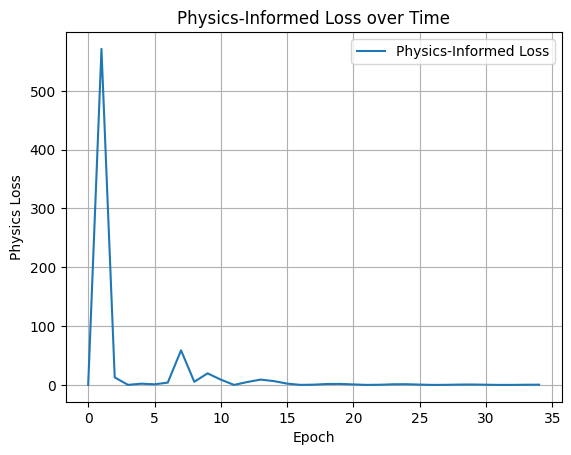

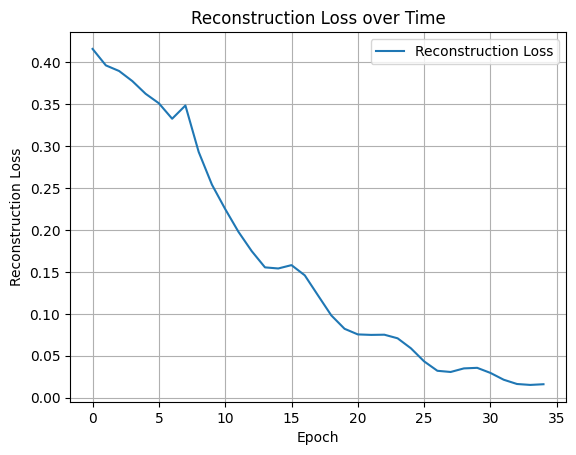

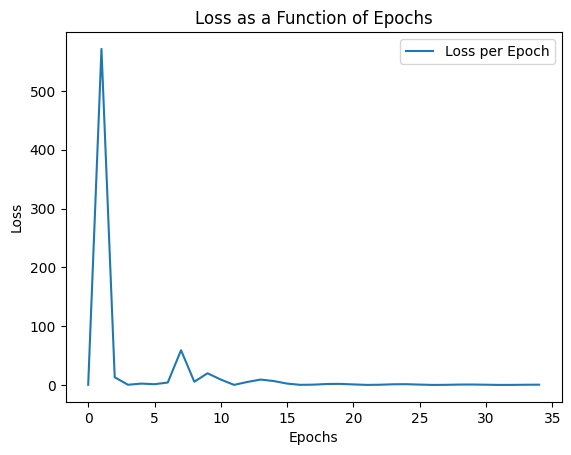

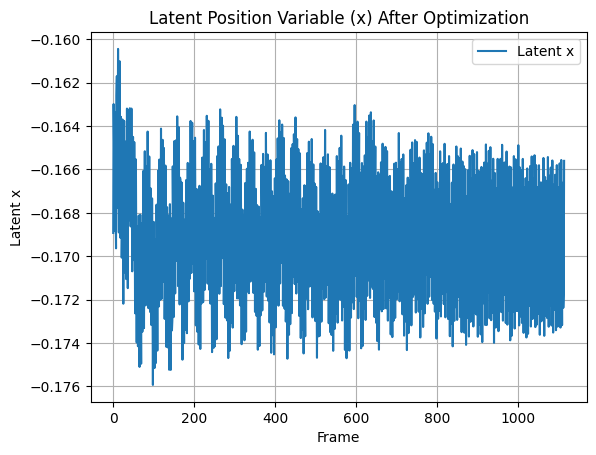

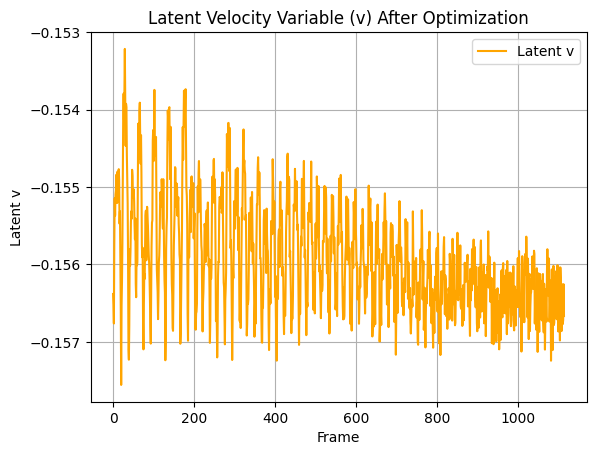

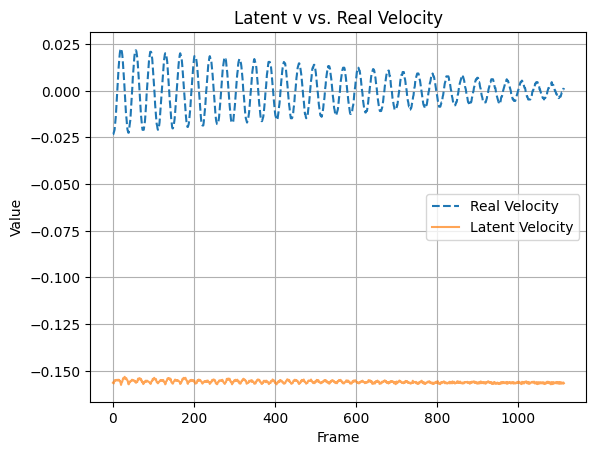

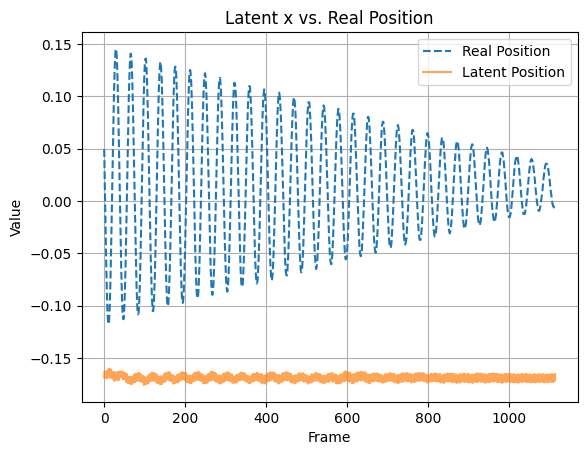

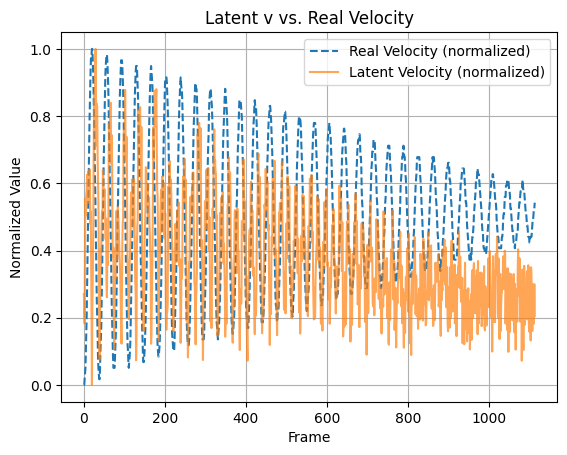

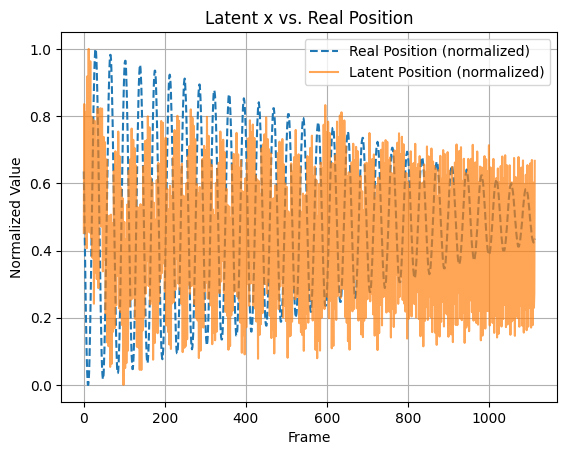

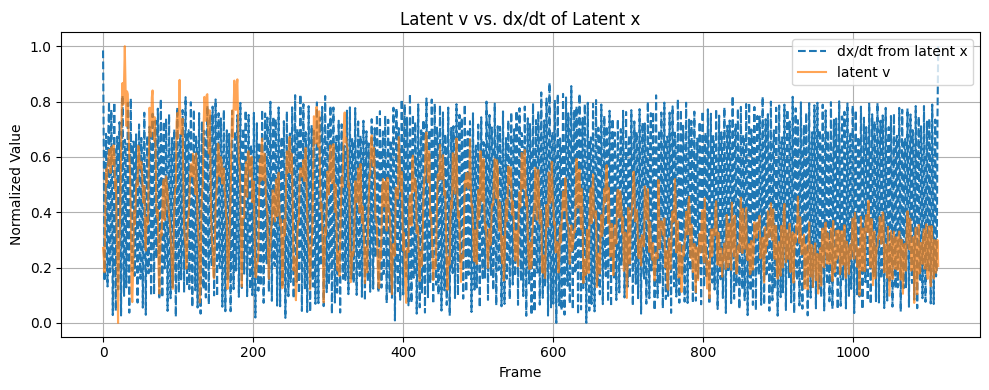

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from data_processing.data_processing2 import images_tensor

class ConvNetAutoencoder_basic(nn.Module):
    def __init__(self, input_shape):
        super(ConvNetAutoencoder_basic, self).__init__()
        self.encoder_conv_layers = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
        )
        # Output Dimension = ((Input dimension +2*padding - kernel_size)/stride) + 1
        # stride is how much we shift after each filter 
        # padding is adding zeros around the edges of your matrix before applying the filter
        # Final dimension is (64,69,25)

        #Dynamically calculate the output shape of the encoder conv layers
        self._get_conv_output(input_shape)

        self.encoder_fc_layers = nn.Sequential(
            nn.Linear(self.num_flat_features, 128),
            nn.ELU(),
            nn.Linear(128, 64),
            nn.ELU(),
            nn.Linear(64, 2),  # Assuming a 2-dimensional latent space
        )

        self.decoder_fc_layers = nn.Sequential(
            nn.Linear(2, 64),
            nn.ELU(),
            nn.Linear(64, 128),
            nn.ELU(),
            nn.Linear(128, self.num_flat_features),
        )

        self.decoder_conv_layers = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
        )
        
    def _get_conv_output(self, shape):
        bs = 1  # Batch size of 1 for testing output shape
        input_tensor = torch.randn(bs, *shape)  # Generate a random tensor without Variable
        with torch.no_grad():  # Disable gradient tracking since this is only for shape calculation
            output_feat = self.encoder_conv_layers(input_tensor)
        self.final_conv_shape = output_feat.shape[1:]  # Store the shape after the last conv layer
        n_size = output_feat.detach().flatten(start_dim=1).size(1)  # Compute flattened size safely
        self.num_flat_features = n_size

    def forward(self, x):
        x = self.encoder_conv_layers(x)
        x = x.view(x.size(0), -1) #Flattening
        x = self.encoder_fc_layers(x)
        latent_vars = x.clone()  # Store latent variables before decoding
        x = self.decoder_fc_layers(x)
        #Use stored shape for dynamic reshaping
        x = x.view(x.size(0), *self.final_conv_shape)
        x = self.decoder_conv_layers(x)
        return x,latent_vars


images_tensor = images_tensor


model = ConvNetAutoencoder_basic(input_shape=(1, 200, 560))
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 35
losses = []
patience = 20
min_delta = 0.01  
latent_epoch_data = []
converged = False
phys_losses = []
reconstruction_losses = []


def physics_informed_loss(x, v, lambda_phys=10):
    dx_dt_estimated = x[1:] - x[:-1]  # Simple finite difference
    phys_loss = F.mse_loss(v[:-1], dx_dt_estimated)  # MSE between estimated derivative and velocity
    return lambda_phys * phys_loss

def smoothness_loss(latent, weight=0.1):
    # latent shape: (batch_size, 2)
    dx = latent[1:] - latent[:-1]  # difference between consecutive latent vectors
    smooth = torch.mean(dx**2)    # L2 smoothness loss
    return weight * smooth

for epoch in range(num_epochs):
    if converged:
        break
    model.train()
    optimizer.zero_grad()

    # Forward pass through the model
    reconstructed, latent_vars = model(images_tensor)

    # Standard reconstruction loss
    reconstruction_loss = loss_fn(reconstructed, images_tensor)

    # Extract latent variables assumed as [x, v]
    x, v = latent_vars[:, 0], latent_vars[:, 1]

    # Calculate the physics-informed loss
    phys_loss = physics_informed_loss(x, v)
    
    x, v = latent_vars[:, 0], latent_vars[:, 1]

    smooth_loss = smoothness_loss(latent_vars, weight=0.1)

    # Total loss is the sum of reconstruction loss and physics-informed loss
    total_loss = 0.5*reconstruction_loss + phys_loss + smooth_loss

    # Backpropagation
    total_loss.backward()
    optimizer.step()

    phys_losses.append(phys_loss.item())
    reconstruction_losses.append(reconstruction_loss.item())
    losses.append(total_loss.item())
    print(f"Epoch: {epoch}, Total Loss: {total_loss.item():.4f}")

    # Early stopping logic
    if epoch > 0 and (losses[-2] - losses[-1] < min_delta):
        if patience > 0:
            patience -= 1
        else:
            print("Early stopping as the model has converged.")
            converged = True

    if epoch % 50 == 0:
        latent_epoch_data.append(latent_vars.detach().cpu().numpy())



latent_values = []

model.eval()
# Forward pass to get the latent variable
with torch.no_grad():
    xe = model.encoder_conv_layers(images_tensor)
    xe = xe.view(xe.size(0), -1)
    latent_variable = model.encoder_fc_layers(xe)

# Convert the lists to numpy arrays for plotting
latent_values = latent_variable.numpy() 


plt.plot(phys_losses, label='Physics-Informed Loss')
plt.xlabel('Epoch')
plt.ylabel('Physics Loss')
plt.title('Physics-Informed Loss over Time')
plt.grid(True)
plt.legend()
plt.show()

plt.plot(reconstruction_losses, label='Reconstruction Loss')
plt.xlabel('Epoch')
plt.ylabel('Reconstruction Loss')
plt.title('Reconstruction Loss over Time')
plt.grid(True)
plt.legend()
plt.show()

plt.plot(losses, label='Loss per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss as a Function of Epochs')
plt.legend()
plt.show()

latent_x = latent_values[:, 0]
latent_v = latent_values[:, 1]

plt.figure()
plt.plot(latent_x, label='Latent x')
plt.xlabel('Frame')
plt.ylabel('Latent x')
plt.title('Latent Position Variable (x) After Optimization')
plt.grid(True)
plt.legend()
plt.show()

plt.figure()
plt.plot(latent_v, label='Latent v', color='orange')
plt.xlabel('Frame')
plt.ylabel('Latent v')
plt.title('Latent Velocity Variable (v) After Optimization')
plt.grid(True)
plt.legend()
plt.show()



plt.plot(vel_m_per_frame, label='Real Velocity ', linestyle='--')
plt.plot(latent_v, label='Latent Velocity', alpha=0.7)
plt.xlabel('Frame')
plt.ylabel('Value')
plt.title('Latent v vs. Real Velocity')
plt.legend()
plt.grid(True)
plt.show()

plt.plot(positions_m, label='Real Position ', linestyle='--')
plt.plot(latent_x, label='Latent Position', alpha=0.7)
plt.xlabel('Frame')
plt.ylabel('Value')
plt.title('Latent x vs. Real Position')
plt.legend()
plt.grid(True)
plt.show()


# Normalize both for visual comparison
latent_v_norm = (latent_v - latent_v.min()) / (latent_v.max() - latent_v.min())
real_v_norm = (vel_m_per_frame - vel_m_per_frame.min()) / (vel_m_per_frame.max() - vel_m_per_frame.min())

plt.plot(real_v_norm, label='Real Velocity (normalized)', linestyle='--')
plt.plot(latent_v_norm, label='Latent Velocity (normalized)', alpha=0.7)
plt.xlabel('Frame')
plt.ylabel('Normalized Value')
plt.title('Latent v vs. Real Velocity')
plt.legend()
plt.grid(True)
plt.show()

latent_x_norm = (latent_x - latent_x.min()) / (latent_x.max() - latent_x.min())
real_x_norm = (positions_m - positions_m.min()) / (positions_m.max() - positions_m.min())

plt.plot(real_x_norm, label='Real Position (normalized)', linestyle='--')
plt.plot(latent_x_norm, label='Latent Position (normalized)', alpha=0.7)
plt.xlabel('Frame')
plt.ylabel('Normalized Value')
plt.title('Latent x vs. Real Position')
plt.legend()
plt.grid(True)
plt.show()


# Use backward finite difference
dx_dt_from_latent = latent_x[1:] - latent_x[:-1]  # shape: (T - 1,)
latent_v_trimmed = latent_v[1:]                   # match shape (T - 1,)

# Normalize both
dx_dt_norm = (dx_dt_from_latent - dx_dt_from_latent.min()) / (dx_dt_from_latent.max() - dx_dt_from_latent.min())
latent_v_norm = (latent_v_trimmed - latent_v_trimmed.min()) / (latent_v_trimmed.max() - latent_v_trimmed.min())

# Plot
plt.figure(figsize=(10, 4))
plt.plot(dx_dt_norm, label='dx/dt from latent x (backward diff)', linestyle='--')
plt.plot(latent_v_norm, label='latent v', alpha=0.7)
plt.xlabel('Frame')
plt.ylabel('Normalized Value')
plt.title('Latent v vs. dx/dt of Latent x (Using Backward Difference)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()



Epoch: 0, Total Loss: 0.4701
Epoch: 1, Total Loss: 413.3137
Epoch: 2, Total Loss: 21.1096
Epoch: 3, Total Loss: 1.4143
Epoch: 4, Total Loss: 0.7472
Epoch: 5, Total Loss: 2.5968
Epoch: 6, Total Loss: 2.7331
Epoch: 7, Total Loss: 0.7242
Epoch: 8, Total Loss: 1.7560
Epoch: 9, Total Loss: 4.3371
Epoch: 10, Total Loss: 2.9330
Epoch: 11, Total Loss: 0.5795
Epoch: 12, Total Loss: 0.9011
Epoch: 13, Total Loss: 1.8221
Epoch: 14, Total Loss: 1.6224
Epoch: 15, Total Loss: 0.8810
Epoch: 16, Total Loss: 0.2939
Epoch: 17, Total Loss: 0.2469
Epoch: 18, Total Loss: 0.4901
Epoch: 19, Total Loss: 0.6407
Epoch: 20, Total Loss: 0.5467
Epoch: 21, Total Loss: 0.3135
Epoch: 22, Total Loss: 0.1292
Epoch: 23, Total Loss: 0.0779
Epoch: 24, Total Loss: 0.1271
Epoch: 25, Total Loss: 0.2046
Epoch: 26, Total Loss: 0.2419
Epoch: 27, Total Loss: 0.2145
Epoch: 28, Total Loss: 0.1450
Epoch: 29, Total Loss: 0.0764
Epoch: 30, Total Loss: 0.0411
Epoch: 31, Total Loss: 0.0431
Epoch: 32, Total Loss: 0.0671
Epoch: 33, Total 

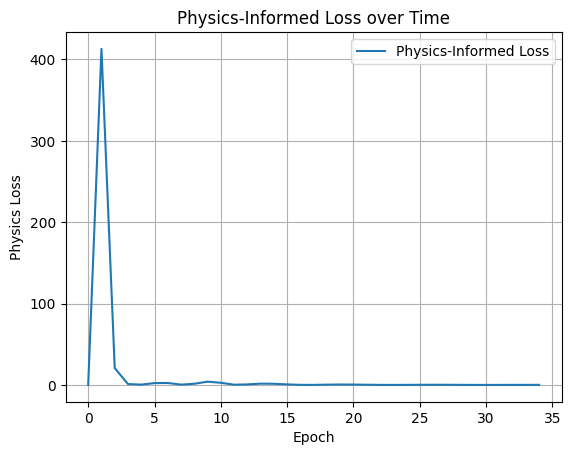

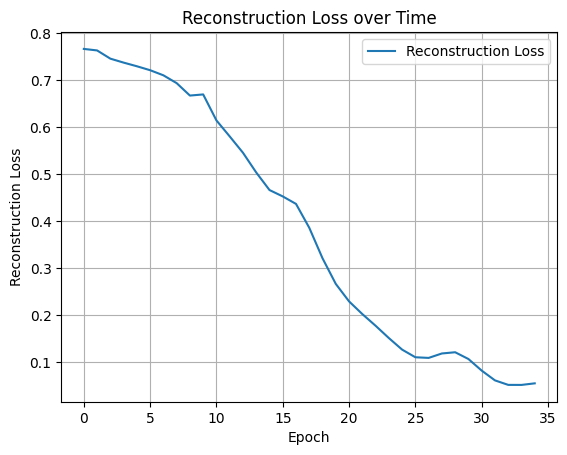

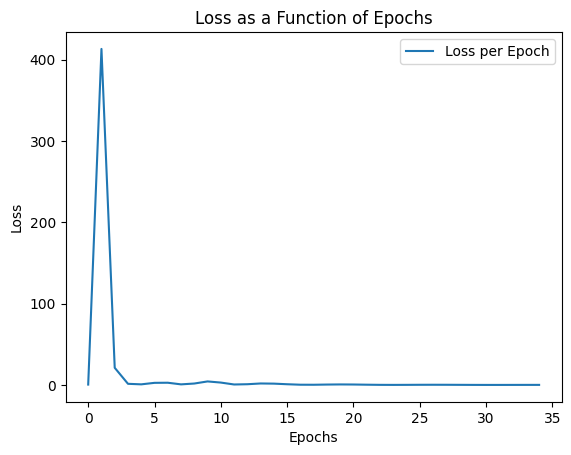

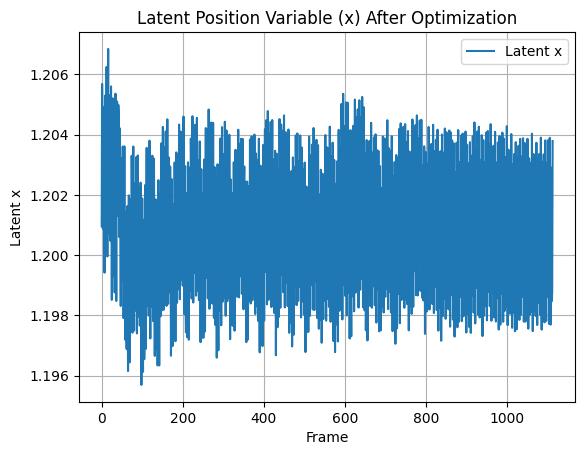

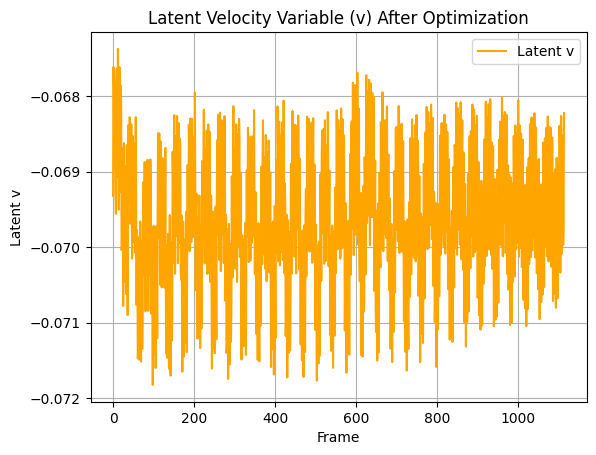

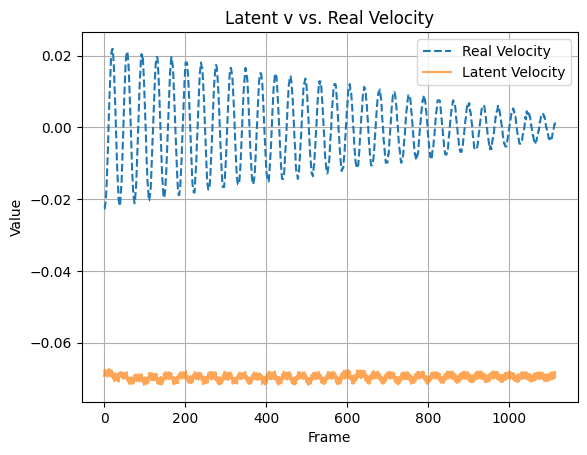

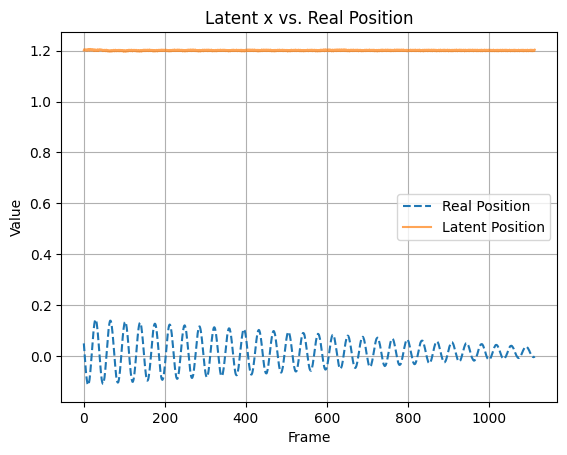

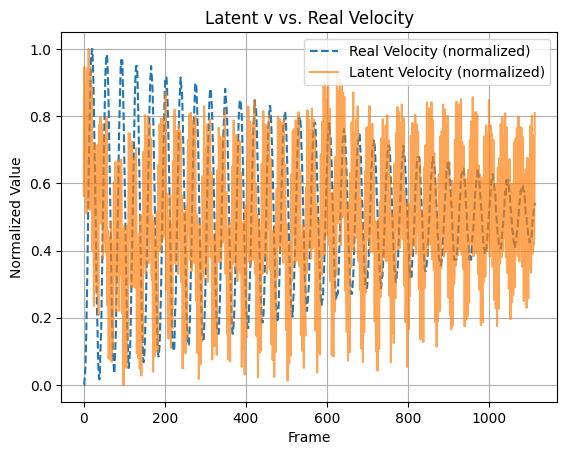

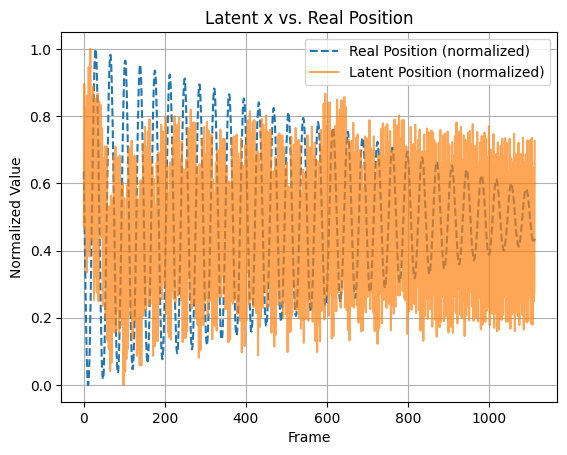

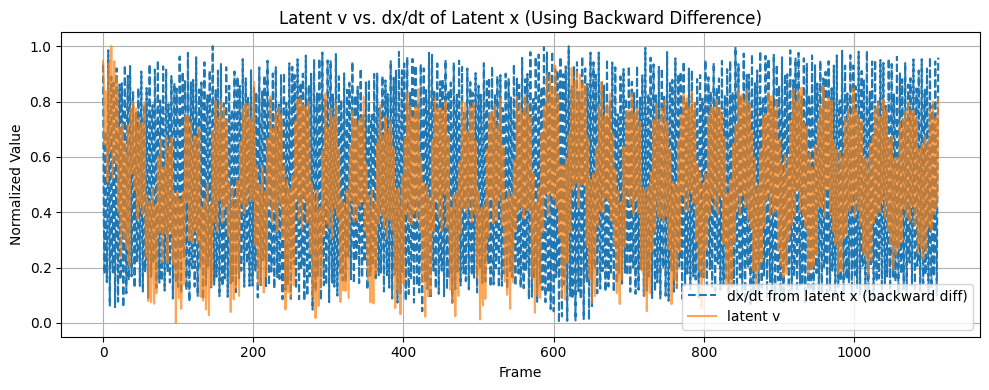

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from data_processing.data_processing2 import images_tensor

class ConvNetAutoencoder_basic(nn.Module):
    def __init__(self, input_shape):
        super(ConvNetAutoencoder_basic, self).__init__()
        self.encoder_conv_layers = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
        )
        # Output Dimension = ((Input dimension +2*padding - kernel_size)/stride) + 1
        # stride is how much we shift after each filter 
        # padding is adding zeros around the edges of your matrix before applying the filter
        # Final dimension is (64,69,25)

        #Dynamically calculate the output shape of the encoder conv layers
        self._get_conv_output(input_shape)

        self.encoder_fc_layers = nn.Sequential(
            nn.Linear(self.num_flat_features, 128),
            nn.ELU(),
            nn.Linear(128, 64),
            nn.ELU(),
            nn.Linear(64, 2),  # Assuming a 2-dimensional latent space
        )

        self.decoder_fc_layers = nn.Sequential(
            nn.Linear(2, 64),
            nn.ELU(),
            nn.Linear(64, 128),
            nn.ELU(),
            nn.Linear(128, self.num_flat_features),
        )

        self.decoder_conv_layers = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
        )
        
    def _get_conv_output(self, shape):
        bs = 1  # Batch size of 1 for testing output shape
        input_tensor = torch.randn(bs, *shape)  # Generate a random tensor without Variable
        with torch.no_grad():  # Disable gradient tracking since this is only for shape calculation
            output_feat = self.encoder_conv_layers(input_tensor)
        self.final_conv_shape = output_feat.shape[1:]  # Store the shape after the last conv layer
        n_size = output_feat.detach().flatten(start_dim=1).size(1)  # Compute flattened size safely
        self.num_flat_features = n_size

    def forward(self, x):
        x = self.encoder_conv_layers(x)
        x = x.view(x.size(0), -1) #Flattening
        x = self.encoder_fc_layers(x)
        latent_vars = x.clone()  # Store latent variables before decoding
        x = self.decoder_fc_layers(x)
        #Use stored shape for dynamic reshaping
        x = x.view(x.size(0), *self.final_conv_shape)
        x = self.decoder_conv_layers(x)
        return x,latent_vars


images_tensor = images_tensor


model = ConvNetAutoencoder_basic(input_shape=(1, 200, 560))
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 35
losses = []
patience = 20
min_delta = 0.01  
latent_epoch_data = []
converged = False
phys_losses = []
reconstruction_losses = []


def physics_informed_loss(x, v, lambda_phys=10):
    dx_dt_estimated = x[1:] - x[:-1]  # Simple finite difference
    phys_loss = F.mse_loss(v[:-1], dx_dt_estimated)  # MSE between estimated derivative and velocity
    return lambda_phys * phys_loss

def smoothness_loss(latent, weight=0.1):
    # latent shape: (batch_size, 2)
    dx = latent[1:] - latent[:-1]  # difference between consecutive latent vectors
    smooth = torch.mean(dx**2)    # L2 smoothness loss
    return weight * smooth

for epoch in range(num_epochs):
    if converged:
        break
    model.train()
    optimizer.zero_grad()

    # Forward pass through the model
    reconstructed, latent_vars = model(images_tensor)

    # Standard reconstruction loss
    reconstruction_loss = loss_fn(reconstructed, images_tensor)

    # Extract latent variables assumed as [x, v]
    x, v = latent_vars[:, 0], latent_vars[:, 1]

    # Calculate the physics-informed loss
    phys_loss = physics_informed_loss(x, v)
    
    x, v = latent_vars[:, 0], latent_vars[:, 1]

    smooth_loss = smoothness_loss(latent_vars, weight=0.1)

    # Total loss is the sum of reconstruction loss and physics-informed loss
    total_loss = 0.5*reconstruction_loss + phys_loss + smooth_loss

    # Backpropagation
    total_loss.backward()
    optimizer.step()

    phys_losses.append(phys_loss.item())
    reconstruction_losses.append(reconstruction_loss.item())
    losses.append(total_loss.item())
    print(f"Epoch: {epoch}, Total Loss: {total_loss.item():.4f}")

    # Early stopping logic
    if epoch > 0 and (losses[-2] - losses[-1] < min_delta):
        if patience > 0:
            patience -= 1
        else:
            print("Early stopping as the model has converged.")
            converged = True

    if epoch % 50 == 0:
        latent_epoch_data.append(latent_vars.detach().cpu().numpy())



latent_values = []

model.eval()
# Forward pass to get the latent variable
with torch.no_grad():
    xe = model.encoder_conv_layers(images_tensor)
    xe = xe.view(xe.size(0), -1)
    latent_variable = model.encoder_fc_layers(xe)

# Convert the lists to numpy arrays for plotting
latent_values = latent_variable.numpy() 


plt.plot(phys_losses, label='Physics-Informed Loss')
plt.xlabel('Epoch')
plt.ylabel('Physics Loss')
plt.title('Physics-Informed Loss over Time')
plt.grid(True)
plt.legend()
plt.show()

plt.plot(reconstruction_losses, label='Reconstruction Loss')
plt.xlabel('Epoch')
plt.ylabel('Reconstruction Loss')
plt.title('Reconstruction Loss over Time')
plt.grid(True)
plt.legend()
plt.show()

plt.plot(losses, label='Loss per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss as a Function of Epochs')
plt.legend()
plt.show()

latent_x = latent_values[:, 0]
latent_v = latent_values[:, 1]

plt.figure()
plt.plot(latent_x, label='Latent x')
plt.xlabel('Frame')
plt.ylabel('Latent x')
plt.title('Latent Position Variable (x) After Optimization')
plt.grid(True)
plt.legend()
plt.show()

plt.figure()
plt.plot(latent_v, label='Latent v', color='orange')
plt.xlabel('Frame')
plt.ylabel('Latent v')
plt.title('Latent Velocity Variable (v) After Optimization')
plt.grid(True)
plt.legend()
plt.show()



plt.plot(vel_m_per_frame, label='Real Velocity ', linestyle='--')
plt.plot(latent_v, label='Latent Velocity', alpha=0.7)
plt.xlabel('Frame')
plt.ylabel('Value')
plt.title('Latent v vs. Real Velocity')
plt.legend()
plt.grid(True)
plt.show()

plt.plot(positions_m, label='Real Position ', linestyle='--')
plt.plot(latent_x, label='Latent Position', alpha=0.7)
plt.xlabel('Frame')
plt.ylabel('Value')
plt.title('Latent x vs. Real Position')
plt.legend()
plt.grid(True)
plt.show()


# Normalize both for visual comparison
latent_v_norm = (latent_v - latent_v.min()) / (latent_v.max() - latent_v.min())
real_v_norm = (vel_m_per_frame - vel_m_per_frame.min()) / (vel_m_per_frame.max() - vel_m_per_frame.min())

plt.plot(real_v_norm, label='Real Velocity (normalized)', linestyle='--')
plt.plot(latent_v_norm, label='Latent Velocity (normalized)', alpha=0.7)
plt.xlabel('Frame')
plt.ylabel('Normalized Value')
plt.title('Latent v vs. Real Velocity')
plt.legend()
plt.grid(True)
plt.show()

latent_x_norm = (latent_x - latent_x.min()) / (latent_x.max() - latent_x.min())
real_x_norm = (positions_m - positions_m.min()) / (positions_m.max() - positions_m.min())

plt.plot(real_x_norm, label='Real Position (normalized)', linestyle='--')
plt.plot(latent_x_norm, label='Latent Position (normalized)', alpha=0.7)
plt.xlabel('Frame')
plt.ylabel('Normalized Value')
plt.title('Latent x vs. Real Position')
plt.legend()
plt.grid(True)
plt.show()


# Use backward finite difference
dx_dt_from_latent = latent_x[1:] - latent_x[:-1]  # shape: (T - 1,)
latent_v_trimmed = latent_v[1:]                   # match shape (T - 1,)

# Normalize both
dx_dt_norm = (dx_dt_from_latent - dx_dt_from_latent.min()) / (dx_dt_from_latent.max() - dx_dt_from_latent.min())
latent_v_norm = (latent_v_trimmed - latent_v_trimmed.min()) / (latent_v_trimmed.max() - latent_v_trimmed.min())

# Plot
plt.figure(figsize=(10, 4))
plt.plot(dx_dt_norm, label='dx/dt from latent x (backward diff)', linestyle='--')
plt.plot(latent_v_norm, label='latent v', alpha=0.7)
plt.xlabel('Frame')
plt.ylabel('Normalized Value')
plt.title('Latent v vs. dx/dt of Latent x (Using Backward Difference)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()



This is interesting x(t) is not decaying however v(t) is decaying???? if v is a derivative of x and x is not decaying v wont be decaying. So a problem could be is that our physics informed loss works primarely on v we are checking if x dot = 2nd latent variable which we are assuming to be v. We arent adding a loss that directly works on x actually we arent adding anything that enforces our latent variables to be actual x and v we are just taking the derivative relationship so it is just an internal rl we could add accelaration loss with real damping to try and see what they would look like

So the loss is saying:

“Hey model, make v_latent as close as possible to the derivative of x_latent.”

So what the model must do is:
v latent approx dx_latent/dt

This is one-way supervision.
You’re not supervising or enforcing the opposite

What “Nothing is Forcing x_latent to Actually Generate That dx/dt” Means:

It means:
	•	Your model is free to generate any x_latent it wants
	•	Even an x_latent that is not the integral of v_latent
	•	As long as the derivative of x_latent somewhat resembles v_latent, the physics loss is minimized

So it’s possible (and likely) that:
	•	v_latent learns to decay (to mimic real velocity and reduce total loss)
	•	But x_latent doesn’t decay, because it’s:
	•	Not being penalized if it doesn’t
	•	Only used as input to compute \frac{dx}{dt}

Visual Analogy

Imagine if you’re training a student by saying:

“Your answers must match the solution’s first derivative, but I won’t check your answer directly.”

They can:
	•	Just tweak their answers to have the right slopes
	•	But their actual solution might still be completely off

Similarly:
	•	Your model tunes v_latent to match a slope
	•	But x_latent isn’t being punished if it doesn’t integrate into that slope


Even though this loss says:
v approx frac{dx}{dt}

It doesn’t say:
	•	What kind of function x(t) must be
	•	Whether x(t) is physically valid (e.g., damped)
	•	Whether x(t) and v(t) combine to form correct acceleration


I was thinking about what losses to add. My problem here isnt that I am not getting the oscillation my main problem is that I am not getting the damping effect so my main goal should be to add a loss that acounts for that so I will be adding a dammped acceleration loss. However we have two coefficients in this equation which are alpha and beta accelaration = -alpha x(t) - beta v(t) I will add the first section to get them from my real values

In [ ]:
from sklearn.linear_model import LinearRegression


x_real = positions_m                      # shape (T,)
v_real = np.gradient(x_real)             # velocity
a_real = np.gradient(v_real)             # acceleration

# Slice to same shape
X = np.vstack([x_real[1:-1], v_real[1:-1]]).T  # shape (T-2, 2)
y = a_real[1:-1]  # shape (T-2,)

# Linear regression: a = -alpha * x - beta * v
reg = LinearRegression()
reg.fit(X, -y)

alpha, beta = reg.coef_
print(f"Estimated alpha: {alpha:.4f}, beta: {beta:.4f}")

Estimated alpha: 0.0292, beta: 0.0025


In [7]:
alpha = 0.0292
beta = 0.0025
zeta = beta / (2 * np.sqrt(alpha))
print(f"Damping ratio ζ ≈ {zeta:.4f}")

Damping ratio ζ ≈ 0.0073


alpha tells us the stiffness-related effect how strong the restoring force is beta reflects the damping coefficient how quickly the system loses energy.

alpha: s^-2, beta: s^-1 since system oscillates slowly and has light damping the values make sense. 

Since our damping ratio is less than 1 it means our system is underdamped ie it oscillates.

To visualize how well our model is doing I plotted all the losses I plotted latent 1 and latent 2 also I plotted real v vs latent 1, real x vs latent 2, dxlatent/dt vs latent 2, d^2x/dt^2 vs accelaration (using latent 1 and latent 2), also I plotted the phase space, acceleration + RHS terms=0, and Energy decay over time

Epoch: 0, Total Loss: 0.2009
Epoch: 1, Total Loss: 297.6903
Epoch: 2, Total Loss: 5.3544
Epoch: 3, Total Loss: 3.9004
Epoch: 4, Total Loss: 2.2365
Epoch: 5, Total Loss: 0.2490
Epoch: 6, Total Loss: 0.2439
Epoch: 7, Total Loss: 18.2123
Epoch: 8, Total Loss: 2.2036
Epoch: 9, Total Loss: 1.7724
Epoch: 10, Total Loss: 0.4230
Epoch: 11, Total Loss: 0.1330
Epoch: 12, Total Loss: 0.9042
Epoch: 13, Total Loss: 1.6992
Epoch: 14, Total Loss: 1.6617
Epoch: 15, Total Loss: 0.9475
Epoch: 16, Total Loss: 0.2389
Epoch: 17, Total Loss: 0.0391
Epoch: 18, Total Loss: 0.2783
Epoch: 19, Total Loss: 0.6073
Epoch: 20, Total Loss: 0.6962
Epoch: 21, Total Loss: 0.4870
Epoch: 22, Total Loss: 0.1797
Epoch: 23, Total Loss: 0.0219
Epoch: 24, Total Loss: 0.1009
Epoch: 25, Total Loss: 0.2886
Epoch: 26, Total Loss: 0.3793
Epoch: 27, Total Loss: 0.2908
Epoch: 28, Total Loss: 0.1192
Epoch: 29, Total Loss: 0.0167
Epoch: 30, Total Loss: 0.0472
Epoch: 31, Total Loss: 0.1474
Epoch: 32, Total Loss: 0.2059
Epoch: 33, Total 

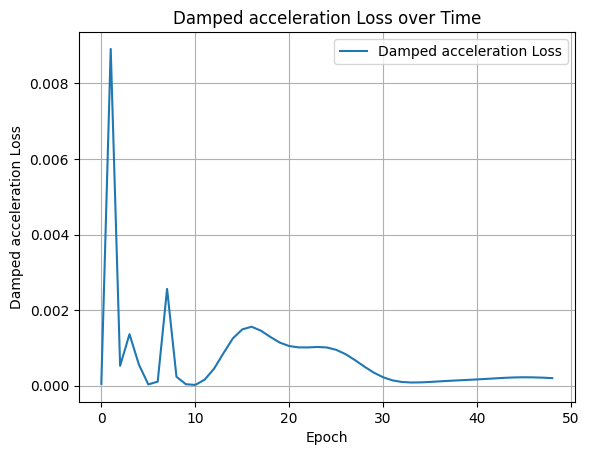

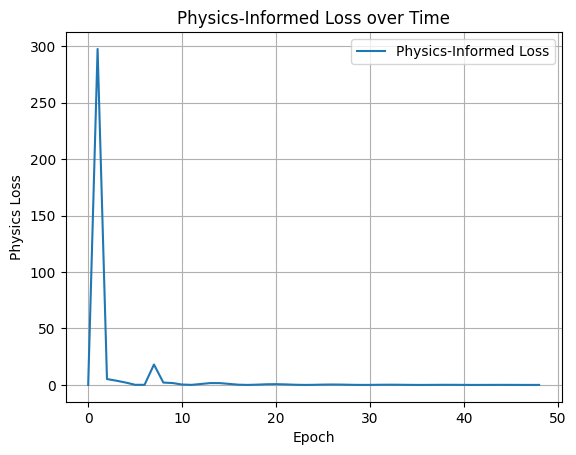

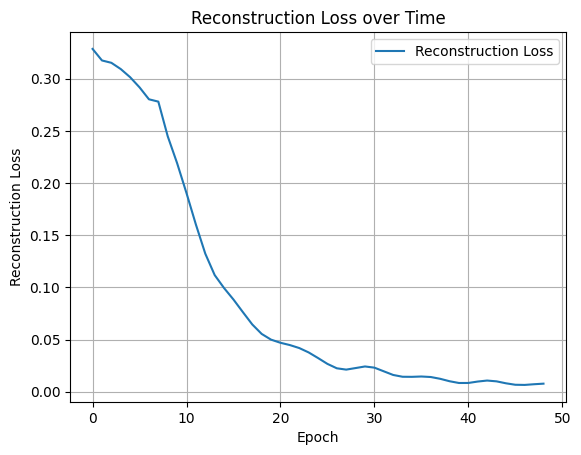

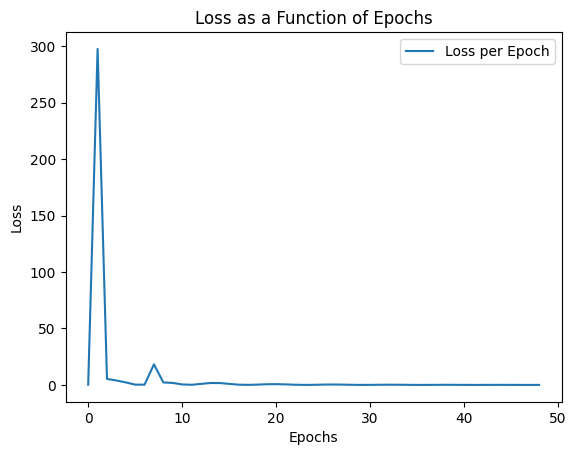

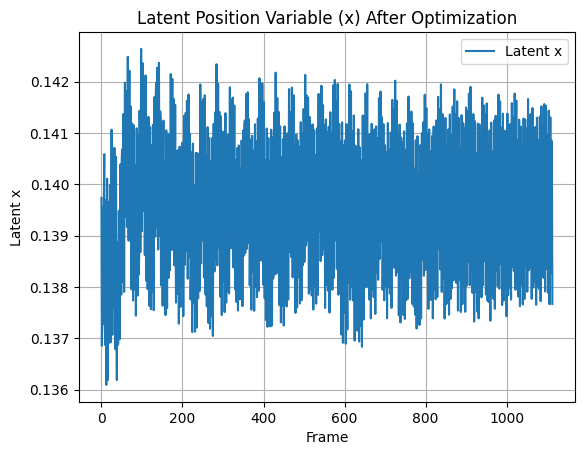

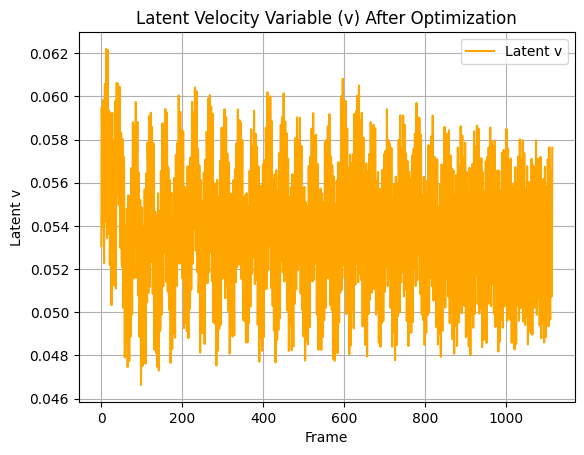

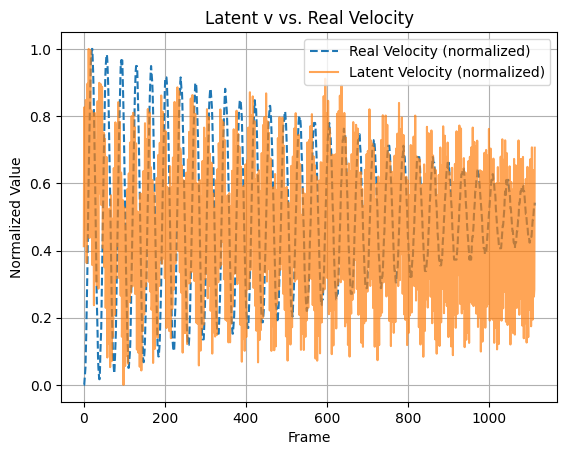

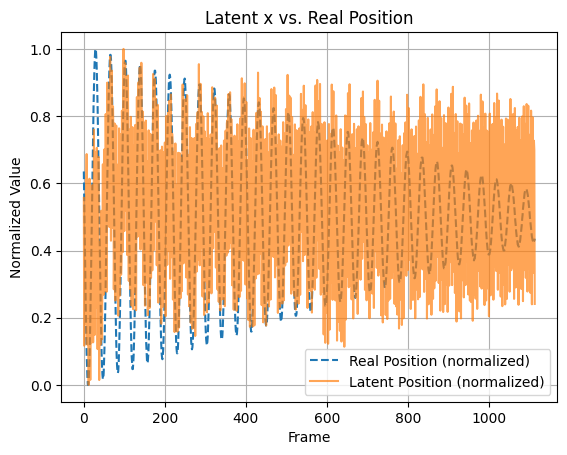

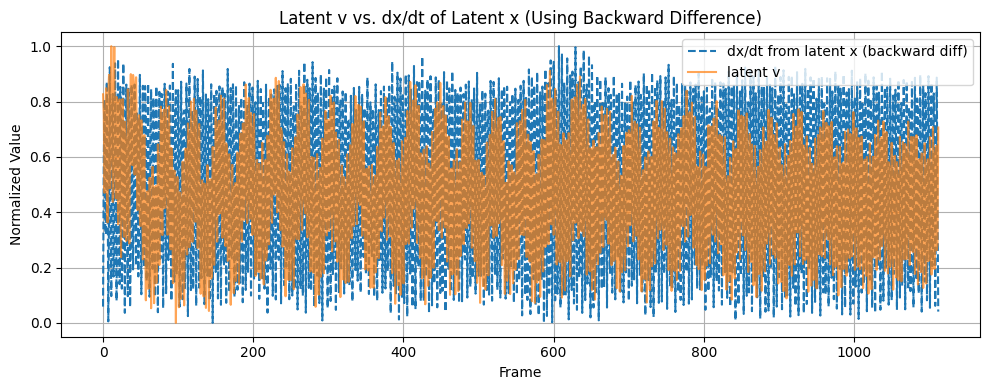

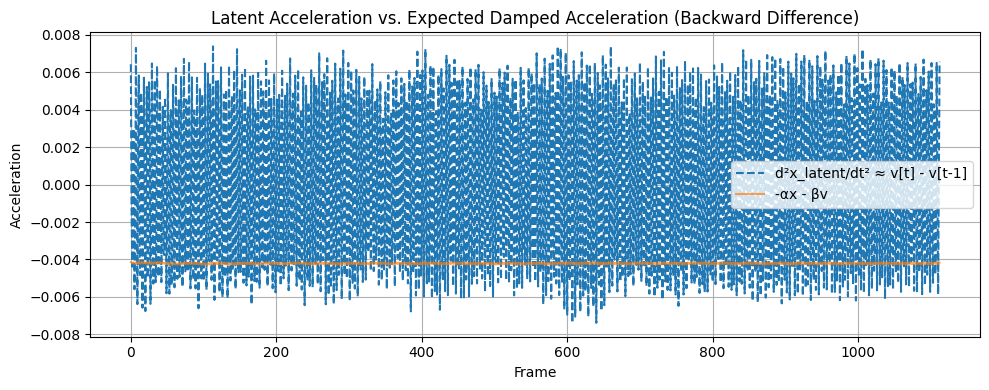

Text(0.5, 1.0, 'Phase Space Trajectory')

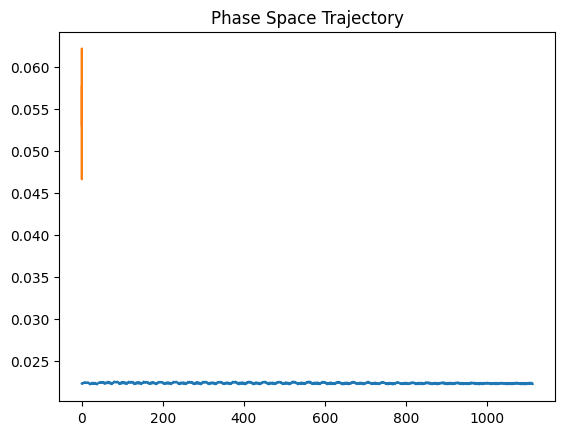

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from data_processing.data_processing2 import images_tensor
import seaborn as sns
import pandas as pd


class ConvNetAutoencoder_basic(nn.Module):
    def __init__(self, input_shape):
        super(ConvNetAutoencoder_basic, self).__init__()
        self.encoder_conv_layers = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
        )
        # Output Dimension = ((Input dimension +2*padding - kernel_size)/stride) + 1
        # stride is how much we shift after each filter 
        # padding is adding zeros around the edges of your matrix before applying the filter
        # Final dimension is (64,69,25)

        #Dynamically calculate the output shape of the encoder conv layers
        self._get_conv_output(input_shape)

        self.encoder_fc_layers = nn.Sequential(
            nn.Linear(self.num_flat_features, 128),
            nn.ELU(),
            nn.Linear(128, 64),
            nn.ELU(),
            nn.Linear(64, 2),  # Assuming a 2-dimensional latent space
        )

        self.decoder_fc_layers = nn.Sequential(
            nn.Linear(2, 64),
            nn.ELU(),
            nn.Linear(64, 128),
            nn.ELU(),
            nn.Linear(128, self.num_flat_features),
        )

        self.decoder_conv_layers = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
        )
        
    def _get_conv_output(self, shape):
        bs = 1  # Batch size of 1 for testing output shape
        input_tensor = torch.randn(bs, *shape)  # Generate a random tensor without Variable
        with torch.no_grad():  # Disable gradient tracking since this is only for shape calculation
            output_feat = self.encoder_conv_layers(input_tensor)
        self.final_conv_shape = output_feat.shape[1:]  # Store the shape after the last conv layer
        n_size = output_feat.detach().flatten(start_dim=1).size(1)  # Compute flattened size safely
        self.num_flat_features = n_size

    def forward(self, x):
        x = self.encoder_conv_layers(x)
        x = x.view(x.size(0), -1) #Flattening
        x = self.encoder_fc_layers(x)
        latent_vars = x.clone()  # Store latent variables before decoding
        x = self.decoder_fc_layers(x)
        #Use stored shape for dynamic reshaping
        x = x.view(x.size(0), *self.final_conv_shape)
        x = self.decoder_conv_layers(x)
        return x,latent_vars


images_tensor = images_tensor


model = ConvNetAutoencoder_basic(input_shape=(1, 200, 560))
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 50
losses = []
patience = 20
min_delta = 0.01  
latent_epoch_data = []
converged = False
phys_losses = []
reconstruction_losses = []
damped_acceleration_losses = []


def physics_informed_loss(x, v, lambda_phys=10):
    dx_dt_estimated = (x[1:] - x[:-1])  # Simple finite difference
    phys_loss = F.mse_loss(v[:-1], dx_dt_estimated)  # MSE between estimated derivative and velocity
    return lambda_phys * phys_loss

def damped_acceleration_loss(latent_x, latent_v, lambda_damp=20, alpha=0.0292, beta=0.0025):
    acc = latent_v[1:] - latent_v[:-1]  # backward finite difference: dv/dt
    x_trim = latent_x[1:]              # match shape
    v_trim = latent_v[1:]              # same points as acc
    expected_acc = -alpha * x_trim - beta * v_trim
    return lambda_damp * F.mse_loss(acc, expected_acc)

def smoothness_loss(latent, weight=0.1):
    # latent shape: (batch_size, 2)
    dx = latent[1:] - latent[:-1]  # difference between consecutive latent vectors
    smooth = torch.mean(dx**2)    # L2 smoothness loss
    return weight * smooth

for epoch in range(num_epochs):
    if converged:
        break
    model.train()
    optimizer.zero_grad()

    # Forward pass through the model
    reconstructed, latent_vars = model(images_tensor)

    # Standard reconstruction loss
    reconstruction_loss = loss_fn(reconstructed, images_tensor)

    # Extract latent variables assumed as [x, v]
    x, v = latent_vars[:, 0], latent_vars[:, 1]

    # Calculate the physics-informed loss
    phys_loss = physics_informed_loss(x, v)
    
    x, v = latent_vars[:, 0], latent_vars[:, 1]

    smooth_loss = smoothness_loss(latent_vars, weight=0.1)

    damp_loss = damped_acceleration_loss(x, v, lambda_damp=5)

    # Total loss is the sum of reconstruction loss and physics-informed loss
    total_loss = 0.5*reconstruction_loss + phys_loss + smooth_loss + damp_loss

    # Backpropagation
    total_loss.backward()
    optimizer.step()

    damped_acceleration_losses.append(damp_loss.item())
    phys_losses.append(phys_loss.item())
    reconstruction_losses.append(reconstruction_loss.item())
    losses.append(total_loss.item())
    print(f"Epoch: {epoch}, Total Loss: {total_loss.item():.4f}")

    # Early stopping logic
    if epoch > 0 and (losses[-2] - losses[-1] < min_delta):
        if patience > 0:
            patience -= 1
        else:
            print("Early stopping as the model has converged.")
            converged = True

    if epoch % 50 == 0:
        latent_epoch_data.append(latent_vars.detach().cpu().numpy())



latent_values = []

model.eval()
# Forward pass to get the latent variable
with torch.no_grad():
    xe = model.encoder_conv_layers(images_tensor)
    xe = xe.view(xe.size(0), -1)
    latent_variable = model.encoder_fc_layers(xe)

# Convert the lists to numpy arrays for plotting
latent_values = latent_variable.numpy() 


plt.plot(damped_acceleration_losses, label='Damped acceleration Loss')
plt.xlabel('Epoch')
plt.ylabel('Damped acceleration Loss')
plt.title('Damped acceleration Loss over Time')
plt.grid(True)
plt.legend()
plt.show()

plt.plot(phys_losses, label='Physics-Informed Loss')
plt.xlabel('Epoch')
plt.ylabel('Physics Loss')
plt.title('Physics-Informed Loss over Time')
plt.grid(True)
plt.legend()
plt.show()

plt.plot(reconstruction_losses, label='Reconstruction Loss')
plt.xlabel('Epoch')
plt.ylabel('Reconstruction Loss')
plt.title('Reconstruction Loss over Time')
plt.grid(True)
plt.legend()
plt.show()

plt.plot(losses, label='Loss per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss as a Function of Epochs')
plt.legend()
plt.show()

latent_x = latent_values[:, 0]
latent_v = latent_values[:, 1]

plt.figure()
plt.plot(latent_x, label='Latent x')
plt.xlabel('Frame')
plt.ylabel('Latent x')
plt.title('Latent Position Variable (x) After Optimization')
plt.grid(True)
plt.legend()
plt.show()

plt.figure()
plt.plot(latent_v, label='Latent v', color='orange')
plt.xlabel('Frame')
plt.ylabel('Latent v')
plt.title('Latent Velocity Variable (v) After Optimization')
plt.grid(True)
plt.legend()
plt.show()


# Normalize both for visual comparison
latent_v_norm = (latent_v - latent_v.min()) / (latent_v.max() - latent_v.min())
real_v_norm = (vel_m_per_frame - vel_m_per_frame.min()) / (vel_m_per_frame.max() - vel_m_per_frame.min())

plt.plot(real_v_norm, label='Real Velocity (normalized)', linestyle='--')
plt.plot(latent_v_norm, label='Latent Velocity (normalized)', alpha=0.7)
plt.xlabel('Frame')
plt.ylabel('Normalized Value')
plt.title('Latent v vs. Real Velocity')
plt.legend()
plt.grid(True)
plt.show()

latent_x_norm = (latent_x - latent_x.min()) / (latent_x.max() - latent_x.min())
real_x_norm = (positions_m - positions_m.min()) / (positions_m.max() - positions_m.min())

plt.plot(real_x_norm, label='Real Position (normalized)', linestyle='--')
plt.plot(latent_x_norm, label='Latent Position (normalized)', alpha=0.7)
plt.xlabel('Frame')
plt.ylabel('Normalized Value')
plt.title('Latent x vs. Real Position')
plt.legend()
plt.grid(True)
plt.show()


# Use backward finite difference
dx_dt_from_latent = latent_x[1:] - latent_x[:-1]  # shape: (T - 1,)
latent_v_trimmed = latent_v[1:]                   # match shape (T - 1,)

# Normalize both
dx_dt_norm = (dx_dt_from_latent - dx_dt_from_latent.min()) / (dx_dt_from_latent.max() - dx_dt_from_latent.min())
latent_v_norm = (latent_v_trimmed - latent_v_trimmed.min()) / (latent_v_trimmed.max() - latent_v_trimmed.min())

# Plot
plt.figure(figsize=(10, 4))
plt.plot(dx_dt_norm, label='dx/dt from latent x (backward diff)', linestyle='--')
plt.plot(latent_v_norm, label='latent v', alpha=0.7)
plt.xlabel('Frame')
plt.ylabel('Normalized Value')
plt.title('Latent v vs. dx/dt of Latent x (Using Backward Difference)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()



alpha = 0.0292
beta = 0.0025

# Approximate d²x/dt² using backward finite difference on v
ddx_latent = latent_v[1:] - latent_v[:-1]  # shape: (T - 1,)

# Match time alignment for x and v
x_trim = latent_x[1:]                      # shape: (T - 1,)
v_trim = latent_v[1:]                      # shape: (T - 1,)
expected_acc = -alpha * x_trim - beta * v_trim

# Plot
plt.figure(figsize=(10, 4))
plt.plot(ddx_latent, label='d²x_latent/dt² ≈ v[t] - v[t-1]', linestyle='--')
plt.plot(expected_acc, label='-αx - βv', alpha=0.7)
plt.xlabel('Frame')
plt.ylabel('Acceleration')
plt.title('Latent Acceleration vs. Expected Damped Acceleration (Backward Difference)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



Epoch: 0, Total Loss: 0.1955
Epoch: 1, Total Loss: 400.3380
Epoch: 2, Total Loss: 5.2873
Epoch: 3, Total Loss: 16.1850
Epoch: 4, Total Loss: 1.5578
Epoch: 5, Total Loss: 0.3872
Epoch: 6, Total Loss: 6.7326
Epoch: 7, Total Loss: 0.2992
Epoch: 8, Total Loss: 2.9277
Epoch: 9, Total Loss: 1.9787
Epoch: 10, Total Loss: 0.2997
Epoch: 11, Total Loss: 1.5652
Epoch: 12, Total Loss: 0.6467
Epoch: 13, Total Loss: 0.0950
Epoch: 14, Total Loss: 0.7044
Epoch: 15, Total Loss: 0.8281
Epoch: 16, Total Loss: 0.2320
Epoch: 17, Total Loss: 0.1366
Epoch: 18, Total Loss: 0.5048
Epoch: 19, Total Loss: 0.3661
Epoch: 20, Total Loss: 0.0429
Epoch: 21, Total Loss: 0.2123
Epoch: 22, Total Loss: 0.3731
Epoch: 23, Total Loss: 0.1349
Epoch: 24, Total Loss: 0.0311
Epoch: 25, Total Loss: 0.1771
Epoch: 26, Total Loss: 0.1946
Epoch: 27, Total Loss: 0.0579
Epoch: 28, Total Loss: 0.0239
Epoch: 29, Total Loss: 0.1087
Epoch: 30, Total Loss: 0.1323
Epoch: 31, Total Loss: 0.0565
Epoch: 32, Total Loss: 0.0098
Epoch: 33, Total 

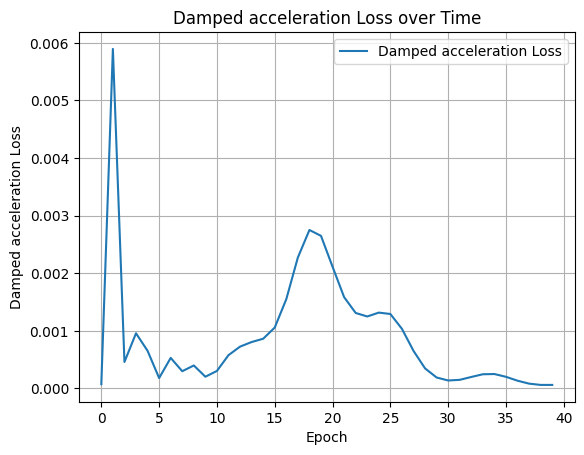

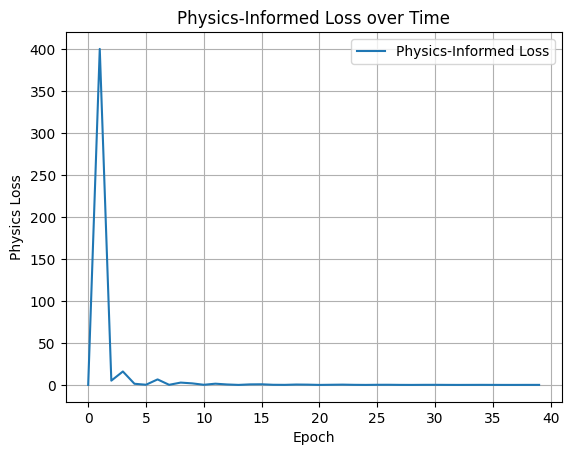

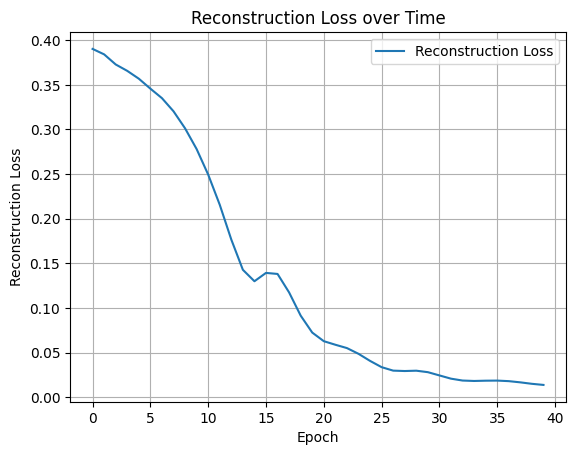

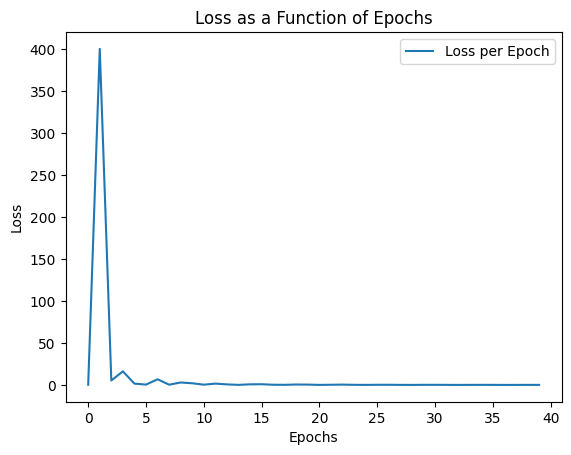

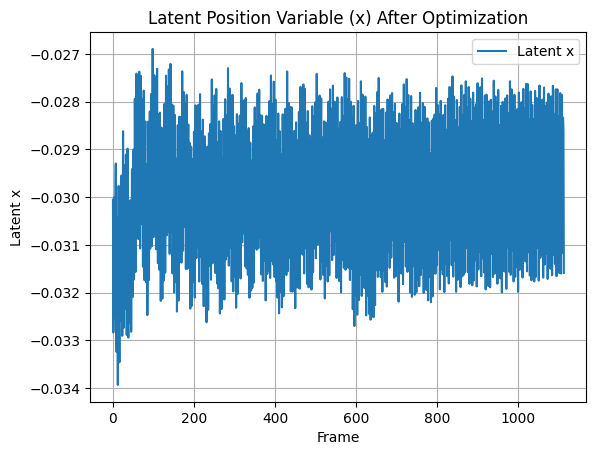

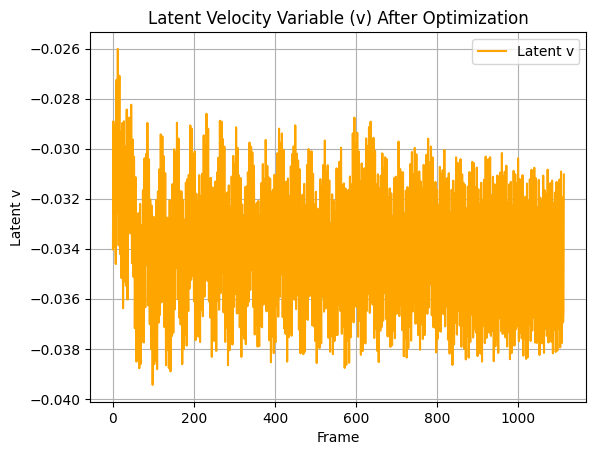

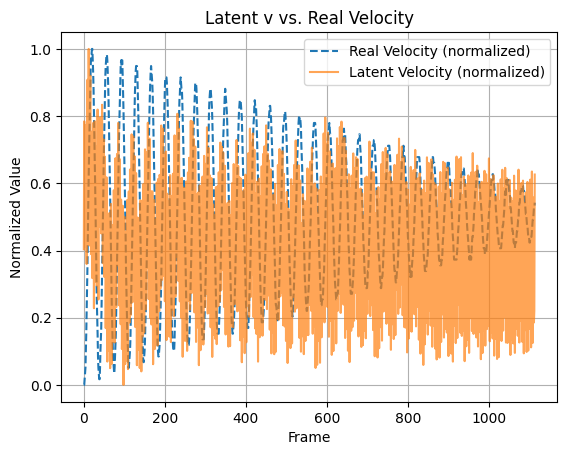

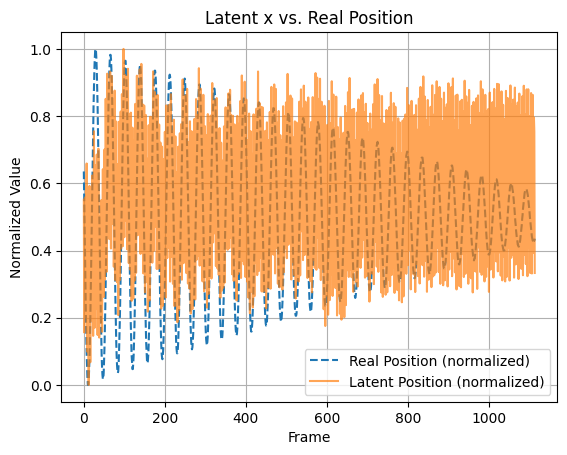

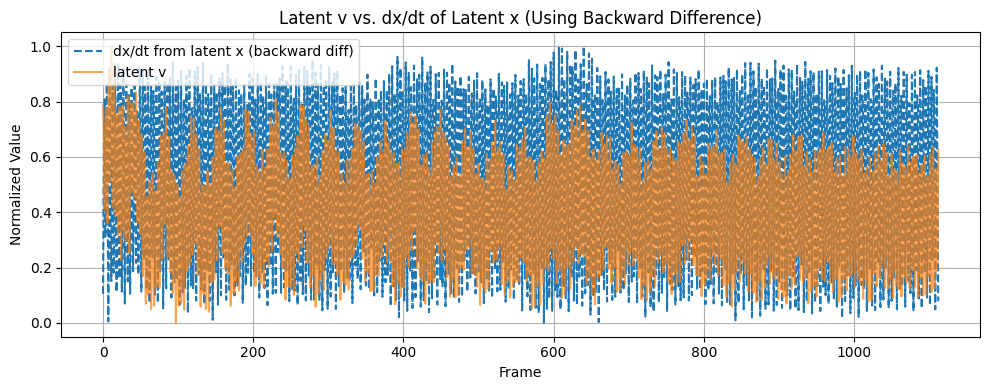

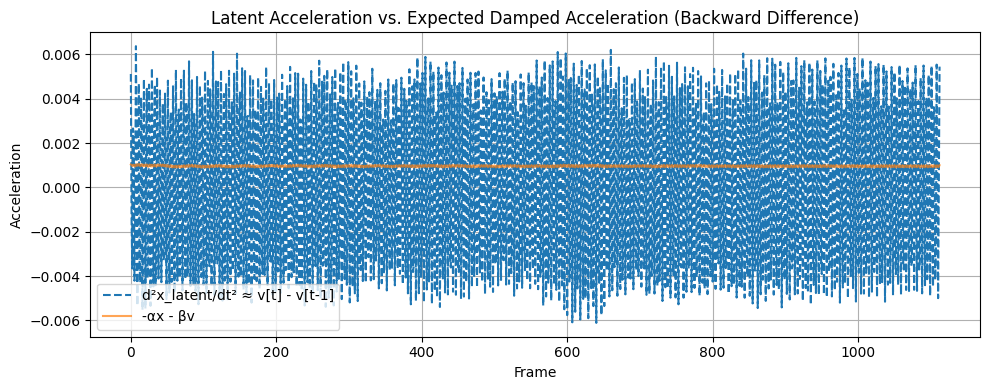

Text(0.5, 1.0, 'Phase Space Trajectory')

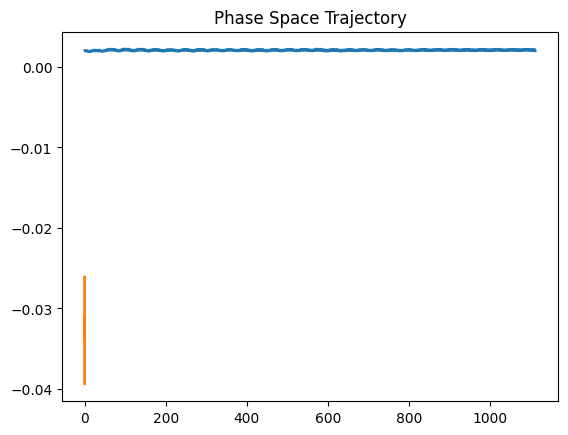

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from data_processing.data_processing2 import images_tensor
import seaborn as sns
import pandas as pd


class ConvNetAutoencoder_basic(nn.Module):
    def __init__(self, input_shape):
        super(ConvNetAutoencoder_basic, self).__init__()
        self.encoder_conv_layers = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
        )
        # Output Dimension = ((Input dimension +2*padding - kernel_size)/stride) + 1
        # stride is how much we shift after each filter 
        # padding is adding zeros around the edges of your matrix before applying the filter
        # Final dimension is (64,69,25)

        #Dynamically calculate the output shape of the encoder conv layers
        self._get_conv_output(input_shape)

        self.encoder_fc_layers = nn.Sequential(
            nn.Linear(self.num_flat_features, 128),
            nn.ELU(),
            nn.Linear(128, 64),
            nn.ELU(),
            nn.Linear(64, 2),  # Assuming a 2-dimensional latent space
        )

        self.decoder_fc_layers = nn.Sequential(
            nn.Linear(2, 64),
            nn.ELU(),
            nn.Linear(64, 128),
            nn.ELU(),
            nn.Linear(128, self.num_flat_features),
        )

        self.decoder_conv_layers = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
        )
        
    def _get_conv_output(self, shape):
        bs = 1  # Batch size of 1 for testing output shape
        input_tensor = torch.randn(bs, *shape)  # Generate a random tensor without Variable
        with torch.no_grad():  # Disable gradient tracking since this is only for shape calculation
            output_feat = self.encoder_conv_layers(input_tensor)
        self.final_conv_shape = output_feat.shape[1:]  # Store the shape after the last conv layer
        n_size = output_feat.detach().flatten(start_dim=1).size(1)  # Compute flattened size safely
        self.num_flat_features = n_size

    def forward(self, x):
        x = self.encoder_conv_layers(x)
        x = x.view(x.size(0), -1) #Flattening
        x = self.encoder_fc_layers(x)
        latent_vars = x.clone()  # Store latent variables before decoding
        x = self.decoder_fc_layers(x)
        #Use stored shape for dynamic reshaping
        x = x.view(x.size(0), *self.final_conv_shape)
        x = self.decoder_conv_layers(x)
        return x,latent_vars


images_tensor = images_tensor


model = ConvNetAutoencoder_basic(input_shape=(1, 200, 560))
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 40
losses = []
patience = 20
min_delta = 0.01  
latent_epoch_data = []
converged = False
phys_losses = []
reconstruction_losses = []
damped_acceleration_losses = []


def physics_informed_loss(x, v, lambda_phys=10):
    dx_dt_estimated = (x[1:] - x[:-1])  # Simple finite difference
    phys_loss = F.mse_loss(v[:-1], dx_dt_estimated)  # MSE between estimated derivative and velocity
    return lambda_phys * phys_loss

def damped_acceleration_loss(latent_x, latent_v, lambda_damp=20, alpha=0.0292, beta=0.0025):
    acc = latent_v[1:] - latent_v[:-1]  # backward finite difference: dv/dt
    x_trim = latent_x[1:]              # match shape
    v_trim = latent_v[1:]              # same points as acc
    expected_acc = -alpha * x_trim - beta * v_trim
    return lambda_damp * F.mse_loss(acc, expected_acc)

def smoothness_loss(latent, weight=0.1):
    # latent shape: (batch_size, 2)
    dx = latent[1:] - latent[:-1]  # difference between consecutive latent vectors
    smooth = torch.mean(dx**2)    # L2 smoothness loss
    return weight * smooth

for epoch in range(num_epochs):
    if converged:
        break
    model.train()
    optimizer.zero_grad()

    # Forward pass through the model
    reconstructed, latent_vars = model(images_tensor)

    # Standard reconstruction loss
    reconstruction_loss = loss_fn(reconstructed, images_tensor)

    
    x, v = latent_vars[:, 0], latent_vars[:, 1]

    # Calculate the physics-informed loss
    phys_loss = physics_informed_loss(x, v)
    
    x, v = latent_vars[:, 0], latent_vars[:, 1]

    smooth_loss = smoothness_loss(latent_vars, weight=0.1)

    damp_loss = damped_acceleration_loss(x, v, lambda_damp=5)

    #energy loss

    latent_x_tensor = latent_x if isinstance(latent_x, torch.Tensor) else torch.tensor(latent_x, dtype=torch.float32)
    latent_v_tensor = latent_v if isinstance(latent_v, torch.Tensor) else torch.tensor(latent_v, dtype=torch.float32)

    # Make sure they’re on the same device as your model
    latent_x_tensor = latent_x_tensor.to(images_tensor.device)
    latent_v_tensor = latent_v_tensor.to(images_tensor.device)

    # Compute energy and energy decay loss
    energy = latent_x_tensor**2 + latent_v_tensor**2  # shape: (T,)
    energy_diff = energy[1:] - energy[:-1]
    energy_decay_loss = F.relu(energy_diff).mean()



    # Total loss is the sum of reconstruction loss and physics-informed loss
    total_loss = 0.5*reconstruction_loss + phys_loss + smooth_loss + damp_loss + (5*energy_decay_loss)

    # Backpropagation
    total_loss.backward()
    optimizer.step()

    damped_acceleration_losses.append(damp_loss.item())
    phys_losses.append(phys_loss.item())
    reconstruction_losses.append(reconstruction_loss.item())
    losses.append(total_loss.item())
    print(f"Epoch: {epoch}, Total Loss: {total_loss.item():.4f}")

    # Early stopping logic
    if epoch > 0 and (losses[-2] - losses[-1] < min_delta):
        if patience > 0:
            patience -= 1
        else:
            print("Early stopping as the model has converged.")
            converged = True

    if epoch % 50 == 0:
        latent_epoch_data.append(latent_vars.detach().cpu().numpy())



latent_values = []

model.eval()
# Forward pass to get the latent variable
with torch.no_grad():
    xe = model.encoder_conv_layers(images_tensor)
    xe = xe.view(xe.size(0), -1)
    latent_variable = model.encoder_fc_layers(xe)

# Convert the lists to numpy arrays for plotting
latent_values = latent_variable.numpy() 


plt.plot(damped_acceleration_losses, label='Damped acceleration Loss')
plt.xlabel('Epoch')
plt.ylabel('Damped acceleration Loss')
plt.title('Damped acceleration Loss over Time')
plt.grid(True)
plt.legend()
plt.show()

plt.plot(phys_losses, label='Physics-Informed Loss')
plt.xlabel('Epoch')
plt.ylabel('Physics Loss')
plt.title('Physics-Informed Loss over Time')
plt.grid(True)
plt.legend()
plt.show()

plt.plot(reconstruction_losses, label='Reconstruction Loss')
plt.xlabel('Epoch')
plt.ylabel('Reconstruction Loss')
plt.title('Reconstruction Loss over Time')
plt.grid(True)
plt.legend()
plt.show()

plt.plot(losses, label='Loss per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss as a Function of Epochs')
plt.legend()
plt.show()

latent_x = latent_values[:, 0]
latent_v = latent_values[:, 1]

plt.figure()
plt.plot(latent_x, label='Latent x')
plt.xlabel('Frame')
plt.ylabel('Latent x')
plt.title('Latent Position Variable (x) After Optimization')
plt.grid(True)
plt.legend()
plt.show()

plt.figure()
plt.plot(latent_v, label='Latent v', color='orange')
plt.xlabel('Frame')
plt.ylabel('Latent v')
plt.title('Latent Velocity Variable (v) After Optimization')
plt.grid(True)
plt.legend()
plt.show()


# Normalize both for visual comparison
latent_v_norm = (latent_v - latent_v.min()) / (latent_v.max() - latent_v.min())
real_v_norm = (vel_m_per_frame - vel_m_per_frame.min()) / (vel_m_per_frame.max() - vel_m_per_frame.min())

plt.plot(real_v_norm, label='Real Velocity (normalized)', linestyle='--')
plt.plot(latent_v_norm, label='Latent Velocity (normalized)', alpha=0.7)
plt.xlabel('Frame')
plt.ylabel('Normalized Value')
plt.title('Latent v vs. Real Velocity')
plt.legend()
plt.grid(True)
plt.show()

latent_x_norm = (latent_x - latent_x.min()) / (latent_x.max() - latent_x.min())
real_x_norm = (positions_m - positions_m.min()) / (positions_m.max() - positions_m.min())

plt.plot(real_x_norm, label='Real Position (normalized)', linestyle='--')
plt.plot(latent_x_norm, label='Latent Position (normalized)', alpha=0.7)
plt.xlabel('Frame')
plt.ylabel('Normalized Value')
plt.title('Latent x vs. Real Position')
plt.legend()
plt.grid(True)
plt.show()


# Use backward finite difference
dx_dt_from_latent = latent_x[1:] - latent_x[:-1]  # shape: (T - 1,)
latent_v_trimmed = latent_v[1:]                   # match shape (T - 1,)

# Normalize both
dx_dt_norm = (dx_dt_from_latent - dx_dt_from_latent.min()) / (dx_dt_from_latent.max() - dx_dt_from_latent.min())
latent_v_norm = (latent_v_trimmed - latent_v_trimmed.min()) / (latent_v_trimmed.max() - latent_v_trimmed.min())

# Plot
plt.figure(figsize=(10, 4))
plt.plot(dx_dt_norm, label='dx/dt from latent x (backward diff)', linestyle='--')
plt.plot(latent_v_norm, label='latent v', alpha=0.7)
plt.xlabel('Frame')
plt.ylabel('Normalized Value')
plt.title('Latent v vs. dx/dt of Latent x (Using Backward Difference)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()



alpha = 0.0292
beta = 0.0025

# Approximate d²x/dt² using backward finite difference on v
ddx_latent = latent_v[1:] - latent_v[:-1]  # shape: (T - 1,)

# Match time alignment for x and v
x_trim = latent_x[1:]                      # shape: (T - 1,)
v_trim = latent_v[1:]                      # shape: (T - 1,)
expected_acc = -alpha * x_trim - beta * v_trim

# Plot
plt.figure(figsize=(10, 4))
plt.plot(ddx_latent, label='d²x_latent/dt² ≈ v[t] - v[t-1]', linestyle='--')
plt.plot(expected_acc, label='-αx - βv', alpha=0.7)
plt.xlabel('Frame')
plt.ylabel('Acceleration')
plt.title('Latent Acceleration vs. Expected Damped Acceleration (Backward Difference)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


energy = latent_x**2 + latent_v**2
plt.plot(energy)
plt.title("Latent Energy Over Time (should decay)")


plt.plot(latent_x, latent_v)
plt.title("Phase Space Trajectory")



Epoch: 0, Total Loss: 0.7165
Epoch: 1, Total Loss: 1350.7943
Epoch: 2, Total Loss: 400.3008
Epoch: 3, Total Loss: 16.9230
Epoch: 4, Total Loss: 0.9616
Epoch: 5, Total Loss: 7.6410
Epoch: 6, Total Loss: 5.4803
Epoch: 7, Total Loss: 8.7342
Epoch: 8, Total Loss: 3.8579
Epoch: 9, Total Loss: 1.0187
Epoch: 10, Total Loss: 2.8739
Epoch: 11, Total Loss: 0.8290
Epoch: 12, Total Loss: 2.1895
Epoch: 13, Total Loss: 1.9001
Epoch: 14, Total Loss: 0.6278
Epoch: 15, Total Loss: 1.3794
Epoch: 16, Total Loss: 1.1707
Epoch: 17, Total Loss: 0.5703
Epoch: 18, Total Loss: 1.3218
Epoch: 19, Total Loss: 0.7464
Epoch: 20, Total Loss: 0.5427
Epoch: 21, Total Loss: 0.9021
Epoch: 22, Total Loss: 0.5143
Epoch: 23, Total Loss: 0.3685
Epoch: 24, Total Loss: 0.6722
Epoch: 25, Total Loss: 0.3987
Epoch: 26, Total Loss: 0.4014
Epoch: 27, Total Loss: 0.5339
Epoch: 28, Total Loss: 0.2967
Epoch: 29, Total Loss: 0.3042
Epoch: 30, Total Loss: 0.4291
Epoch: 31, Total Loss: 0.2339
Epoch: 32, Total Loss: 0.2307
Epoch: 33, Tot

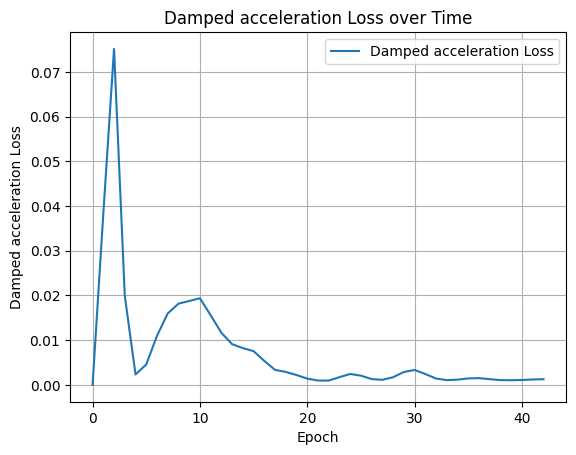

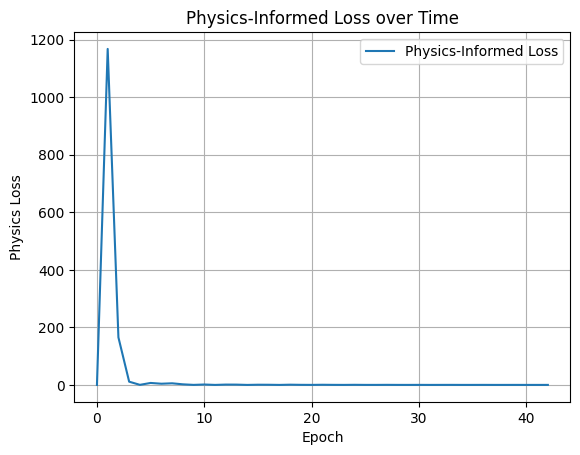

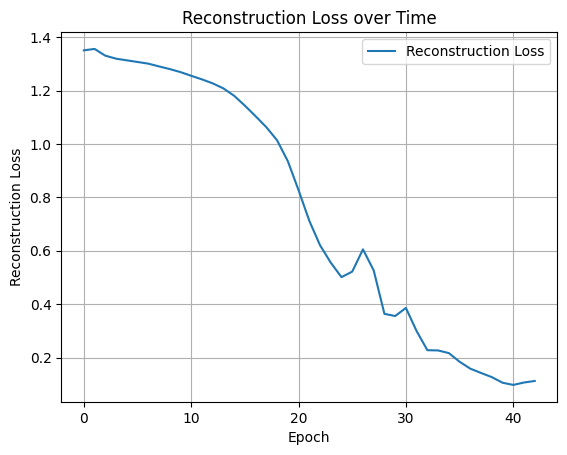

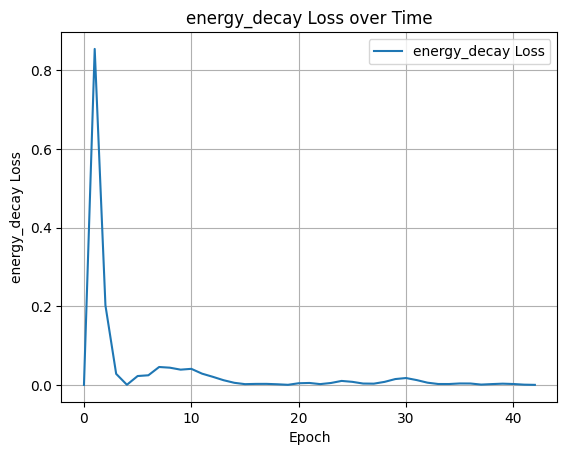

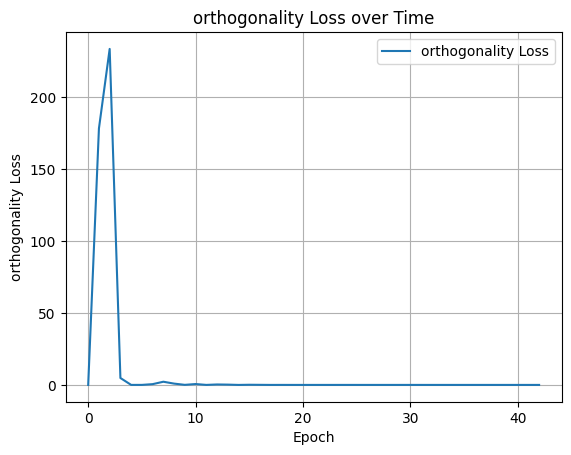

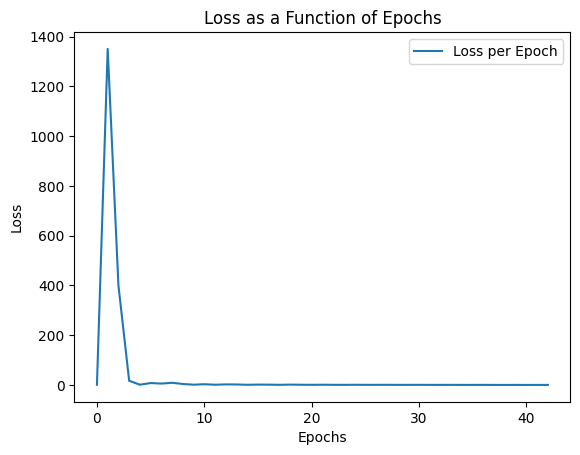

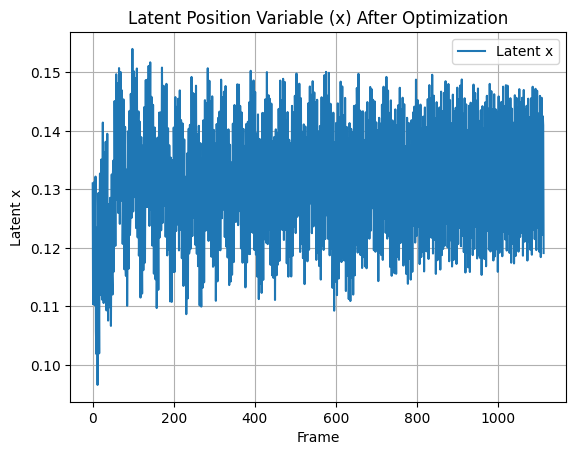

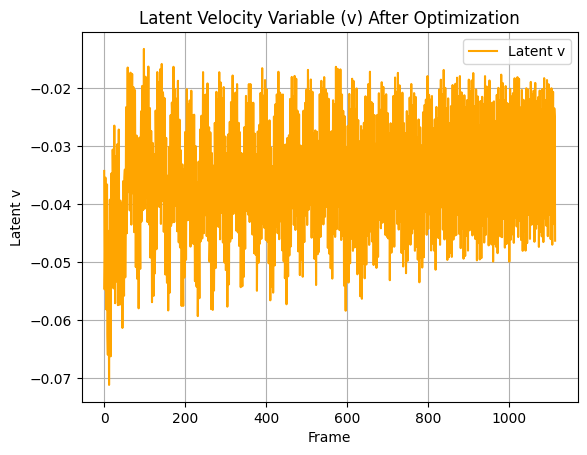

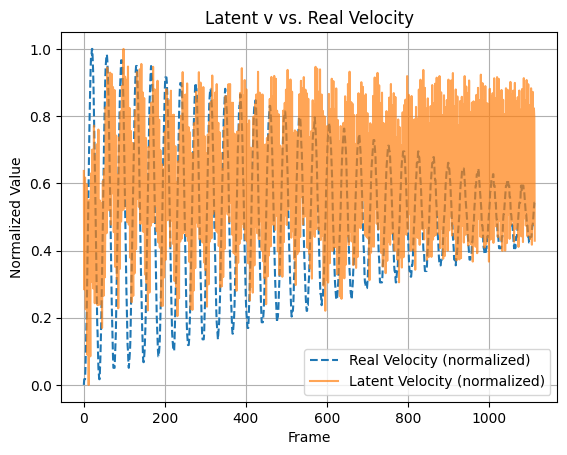

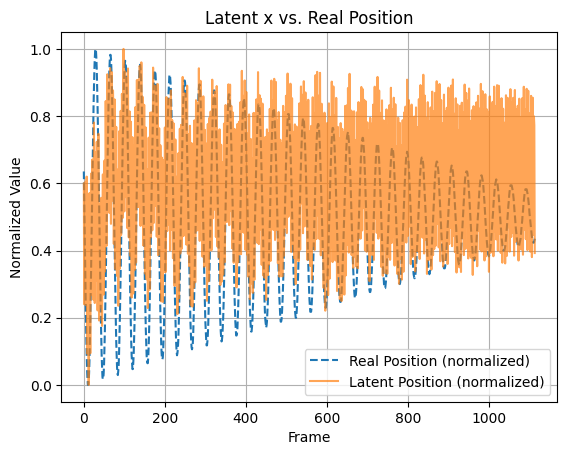

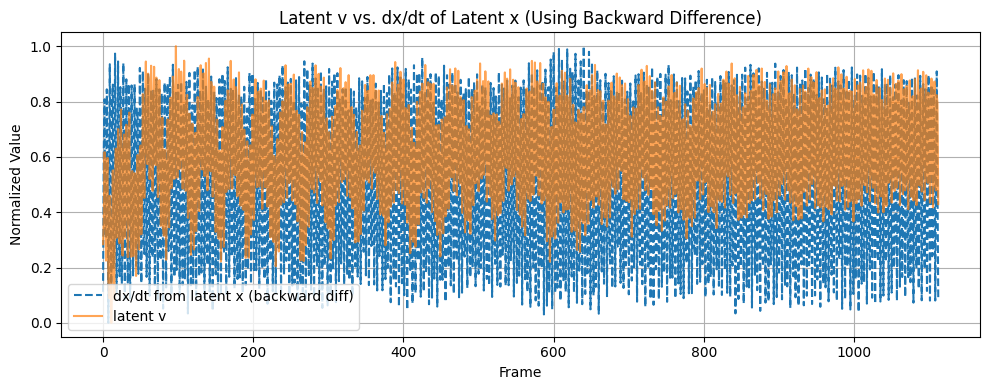

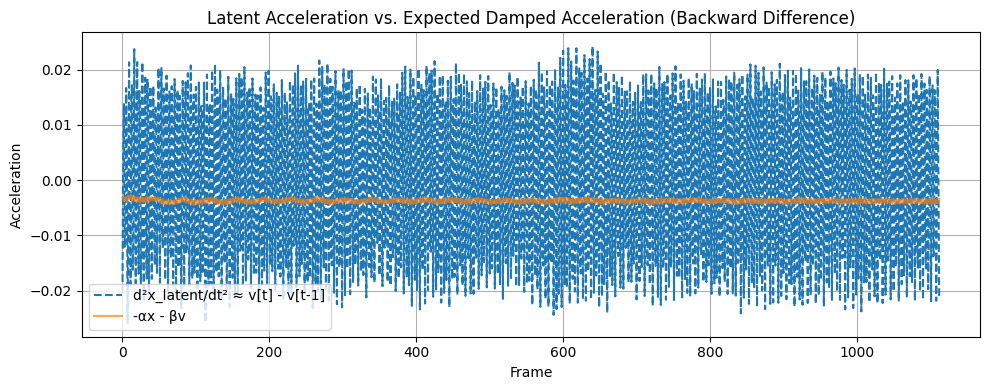

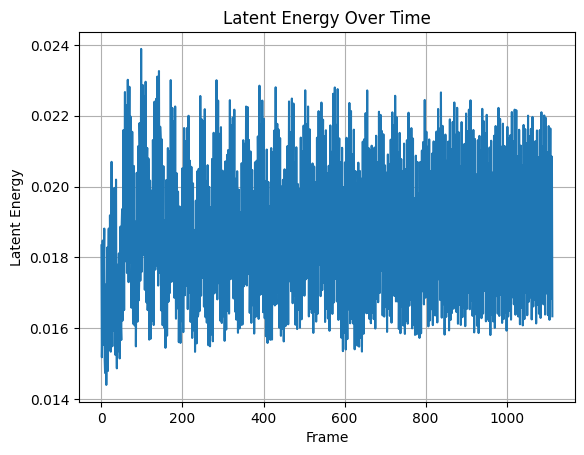

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from data_processing.data_processing2 import images_tensor
import seaborn as sns
import pandas as pd


class ConvNetAutoencoder_basic(nn.Module):
    def __init__(self, input_shape):
        super(ConvNetAutoencoder_basic, self).__init__()
        self.encoder_conv_layers = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
        )
        # Output Dimension = ((Input dimension +2*padding - kernel_size)/stride) + 1
        # stride is how much we shift after each filter 
        # padding is adding zeros around the edges of your matrix before applying the filter
        # Final dimension is (64,69,25)

        #Dynamically calculate the output shape of the encoder conv layers
        self._get_conv_output(input_shape)

        self.encoder_fc_layers = nn.Sequential(
            nn.Linear(self.num_flat_features, 128),
            nn.ELU(),
            nn.Linear(128, 64),
            nn.ELU(),
            nn.Linear(64, 2),  # Assuming a 2-dimensional latent space
        )

        self.decoder_fc_layers = nn.Sequential(
            nn.Linear(2, 64),
            nn.ELU(),
            nn.Linear(64, 128),
            nn.ELU(),
            nn.Linear(128, self.num_flat_features),
        )

        self.decoder_conv_layers = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
        )
        
    def _get_conv_output(self, shape):
        bs = 1  # Batch size of 1 for testing output shape
        input_tensor = torch.randn(bs, *shape)  # Generate a random tensor without Variable
        with torch.no_grad():  # Disable gradient tracking since this is only for shape calculation
            output_feat = self.encoder_conv_layers(input_tensor)
        self.final_conv_shape = output_feat.shape[1:]  # Store the shape after the last conv layer
        n_size = output_feat.detach().flatten(start_dim=1).size(1)  # Compute flattened size safely
        self.num_flat_features = n_size

    def forward(self, x):
        x = self.encoder_conv_layers(x)
        x = x.view(x.size(0), -1) #Flattening
        x = self.encoder_fc_layers(x)
        latent_vars = x.clone()  # Store latent variables before decoding
        x = self.decoder_fc_layers(x)
        #Use stored shape for dynamic reshaping
        x = x.view(x.size(0), *self.final_conv_shape)
        x = self.decoder_conv_layers(x)
        return x,latent_vars


images_tensor = images_tensor


model = ConvNetAutoencoder_basic(input_shape=(1, 200, 560))
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 100
losses = []
patience = 20
min_delta = 0.01  
latent_epoch_data = []
converged = False
phys_losses = []
reconstruction_losses = []
damped_acceleration_losses = []
energy_decay_losses = []
orthogonality_losses = []

def physics_informed_loss(x, v, lambda_phys=10):
    dx_dt_estimated = (x[1:] - x[:-1])  # Simple finite difference
    phys_loss = F.mse_loss(v[:-1], dx_dt_estimated)  # MSE between estimated derivative and velocity
    return lambda_phys * phys_loss

def damped_acceleration_loss(latent_x, latent_v, lambda_damp=20, alpha=0.0292, beta=0.0025):
    acc = latent_v[1:] - latent_v[:-1]  # backward finite difference: dv/dt
    x_trim = latent_x[1:]              # match shape
    v_trim = latent_v[1:]              # same points as acc
    expected_acc = -alpha * x_trim - beta * v_trim
    return lambda_damp * F.mse_loss(acc, expected_acc)

def smoothness_loss(latent, weight=0.1):
    # latent shape: (batch_size, 2)
    dx = latent[1:] - latent[:-1]  # difference between consecutive latent vectors
    smooth = torch.mean(dx**2)    # L2 smoothness loss
    return weight * smooth

for epoch in range(num_epochs):
    if converged:
        break
    model.train()
    optimizer.zero_grad()

    # Forward pass through the model
    reconstructed, latent_vars = model(images_tensor)

    # Standard reconstruction loss
    reconstruction_loss = loss_fn(reconstructed, images_tensor)

    # Extract latent variables assumed as [x, v]
    x, v = latent_vars[:, 0], latent_vars[:, 1]

    # Calculate the physics-informed loss
    phys_loss = physics_informed_loss(x, v)
    
    x, v = latent_vars[:, 0], latent_vars[:, 1]

    smooth_loss = smoothness_loss(latent_vars, weight=0.1)

    damp_loss = damped_acceleration_loss(x, v, lambda_damp=5)

    #energy loss
    # Convert to PyTorch tensors if they're not already
    latent_x_tensor = x
    latent_v_tensor = v
    energy = latent_x_tensor**2 + latent_v_tensor**2
    energy_diff = energy[1:] - energy[:-1]
    energy_decay_loss = F.relu(energy_diff).mean()

    orthogonality_loss = torch.mean(latent_x_tensor * latent_v_tensor)


    #orthg loss
    # Force latent_x and latent_v to be uncorrelated (orthogonal)
    orthogonality_loss = torch.mean((latent_x_tensor * latent_v_tensor)**2)

    # Total loss is the sum of reconstruction loss and physics-informed loss
    total_loss = 0.5*reconstruction_loss + phys_loss + smooth_loss + damp_loss + (5*energy_decay_loss) + orthogonality_loss

    # Backpropagation
    total_loss.backward()
    optimizer.step()

    damped_acceleration_losses.append(damp_loss.item())
    phys_losses.append(phys_loss.item())
    reconstruction_losses.append(reconstruction_loss.item())
    losses.append(total_loss.item())
    energy_decay_losses.append(energy_decay_loss.item())
    orthogonality_losses.append(orthogonality_loss.item())
    print(f"Epoch: {epoch}, Total Loss: {total_loss.item():.4f}")

    # Early stopping logic
    if epoch > 0 and (losses[-2] - losses[-1] < min_delta):
        if patience > 0:
            patience -= 1
        else:
            print("Early stopping as the model has converged.")
            converged = True

    if epoch % 50 == 0:
        latent_epoch_data.append(latent_vars.detach().cpu().numpy())



latent_values = []

model.eval()
# Forward pass to get the latent variable
with torch.no_grad():
    xe = model.encoder_conv_layers(images_tensor)
    xe = xe.view(xe.size(0), -1)
    latent_variable = model.encoder_fc_layers(xe)

# Convert the lists to numpy arrays for plotting
latent_values = latent_variable.numpy() 


plt.plot(damped_acceleration_losses, label='Damped acceleration Loss')
plt.xlabel('Epoch')
plt.ylabel('Damped acceleration Loss')
plt.title('Damped acceleration Loss over Time')
plt.grid(True)
plt.legend()
plt.show()

plt.plot(phys_losses, label='Physics-Informed Loss')
plt.xlabel('Epoch')
plt.ylabel('Physics Loss')
plt.title('Physics-Informed Loss over Time')
plt.grid(True)
plt.legend()
plt.show()

plt.plot(reconstruction_losses, label='Reconstruction Loss')
plt.xlabel('Epoch')
plt.ylabel('Reconstruction Loss')
plt.title('Reconstruction Loss over Time')
plt.grid(True)
plt.legend()
plt.show()

plt.plot(energy_decay_losses, label='energy_decay Loss')
plt.xlabel('Epoch')
plt.ylabel('energy_decay Loss')
plt.title('energy_decay Loss over Time')
plt.grid(True)
plt.legend()
plt.show()

plt.plot(orthogonality_losses, label='orthogonality Loss')
plt.xlabel('Epoch')
plt.ylabel('orthogonality Loss')
plt.title('orthogonality Loss over Time')
plt.grid(True)
plt.legend()
plt.show()

plt.plot(losses, label='Loss per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss as a Function of Epochs')
plt.legend()
plt.show()

latent_x = latent_values[:, 0]
latent_v = latent_values[:, 1]

plt.figure()
plt.plot(latent_x, label='Latent x')
plt.xlabel('Frame')
plt.ylabel('Latent x')
plt.title('Latent Position Variable (x) After Optimization')
plt.grid(True)
plt.legend()
plt.show()

plt.figure()
plt.plot(latent_v, label='Latent v', color='orange')
plt.xlabel('Frame')
plt.ylabel('Latent v')
plt.title('Latent Velocity Variable (v) After Optimization')
plt.grid(True)
plt.legend()
plt.show()


# Normalize both for visual comparison
latent_v_norm = (latent_v - latent_v.min()) / (latent_v.max() - latent_v.min())
real_v_norm = (vel_m_per_frame - vel_m_per_frame.min()) / (vel_m_per_frame.max() - vel_m_per_frame.min())

plt.plot(real_v_norm, label='Real Velocity (normalized)', linestyle='--')
plt.plot(latent_v_norm, label='Latent Velocity (normalized)', alpha=0.7)
plt.xlabel('Frame')
plt.ylabel('Normalized Value')
plt.title('Latent v vs. Real Velocity')
plt.legend()
plt.grid(True)
plt.show()

latent_x_norm = (latent_x - latent_x.min()) / (latent_x.max() - latent_x.min())
real_x_norm = (positions_m - positions_m.min()) / (positions_m.max() - positions_m.min())

plt.plot(real_x_norm, label='Real Position (normalized)', linestyle='--')
plt.plot(latent_x_norm, label='Latent Position (normalized)', alpha=0.7)
plt.xlabel('Frame')
plt.ylabel('Normalized Value')
plt.title('Latent x vs. Real Position')
plt.legend()
plt.grid(True)
plt.show()


# Use backward finite difference
dx_dt_from_latent = latent_x[1:] - latent_x[:-1]  # shape: (T - 1,)
latent_v_trimmed = latent_v[1:]                   # match shape (T - 1,)

# Normalize both
dx_dt_norm = (dx_dt_from_latent - dx_dt_from_latent.min()) / (dx_dt_from_latent.max() - dx_dt_from_latent.min())
latent_v_norm = (latent_v_trimmed - latent_v_trimmed.min()) / (latent_v_trimmed.max() - latent_v_trimmed.min())

# Plot
plt.figure(figsize=(10, 4))
plt.plot(dx_dt_norm, label='dx/dt from latent x (backward diff)', linestyle='--')
plt.plot(latent_v_norm, label='latent v', alpha=0.7)
plt.xlabel('Frame')
plt.ylabel('Normalized Value')
plt.title('Latent v vs. dx/dt of Latent x (Using Backward Difference)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()



alpha = 0.0292
beta = 0.0025

# Approximate d²x/dt² using backward finite difference on v
ddx_latent = latent_v[1:] - latent_v[:-1]  # shape: (T - 1,)

# Match time alignment for x and v
x_trim = latent_x[1:]                      # shape: (T - 1,)
v_trim = latent_v[1:]                      # shape: (T - 1,)
expected_acc = -alpha * x_trim - beta * v_trim

# Plot
plt.figure(figsize=(10, 4))
plt.plot(ddx_latent, label='d²x_latent/dt² ≈ v[t] - v[t-1]', linestyle='--')
plt.plot(expected_acc, label='-αx - βv', alpha=0.7)
plt.xlabel('Frame')
plt.ylabel('Acceleration')
plt.title('Latent Acceleration vs. Expected Damped Acceleration (Backward Difference)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


energy = latent_x**2 + latent_v**2
plt.plot(energy)
plt.xlabel('Frame')
plt.ylabel('Latent Energy')
plt.title('Latent Energy Over Time')
plt.grid(True)
plt.show()




Expected Shape: [num_frames, 1, 200, 560]
Actual Shape: torch.Size([1114, 1, 200, 560])
Epoch: 0, Total Loss: 0.5748
Epoch: 1, Total Loss: 414.2593
Epoch: 2, Total Loss: 7.5434
Epoch: 3, Total Loss: 4.6642
Epoch: 4, Total Loss: 3.4817
Epoch: 5, Total Loss: 1.0022
Epoch: 6, Total Loss: 0.3532
Epoch: 7, Total Loss: 0.3585
Epoch: 8, Total Loss: 1.9976
Epoch: 9, Total Loss: 4.3071
Epoch: 10, Total Loss: 0.5073
Epoch: 11, Total Loss: 2.1965
Epoch: 12, Total Loss: 1.3334
Epoch: 13, Total Loss: 1.5122
Epoch: 14, Total Loss: 0.1863
Epoch: 15, Total Loss: 0.8632
Epoch: 16, Total Loss: 0.7448
Epoch: 17, Total Loss: 0.1172
Epoch: 18, Total Loss: 0.3749
Epoch: 19, Total Loss: 0.5365
Epoch: 20, Total Loss: 0.2351
Epoch: 21, Total Loss: 0.0834
Epoch: 22, Total Loss: 0.2589
Epoch: 23, Total Loss: 0.3057
Epoch: 24, Total Loss: 0.1290
Epoch: 25, Total Loss: 0.0459
Epoch: 26, Total Loss: 0.1395
Epoch: 27, Total Loss: 0.1949
Epoch: 28, Total Loss: 0.1116
Epoch: 29, Total Loss: 0.0254
Epoch: 30, Total Los

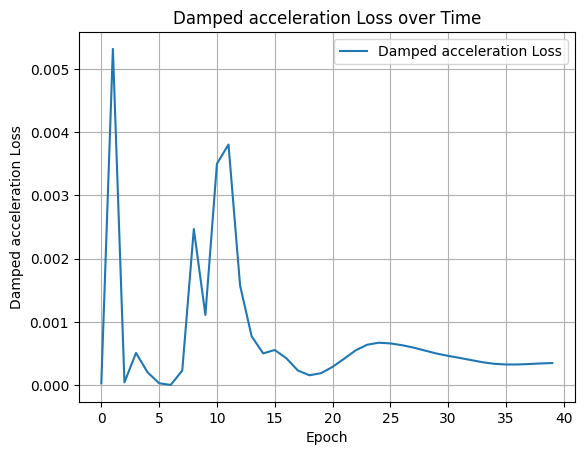

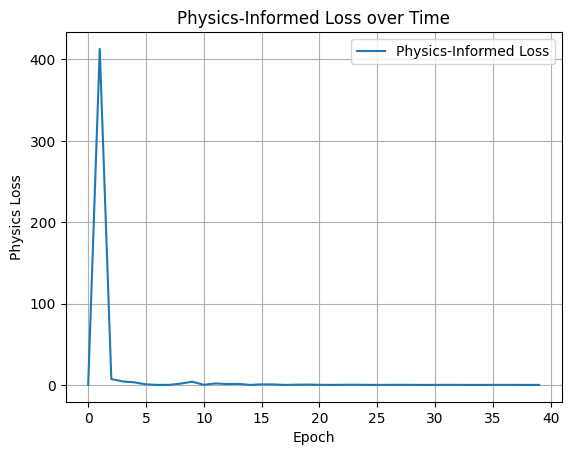

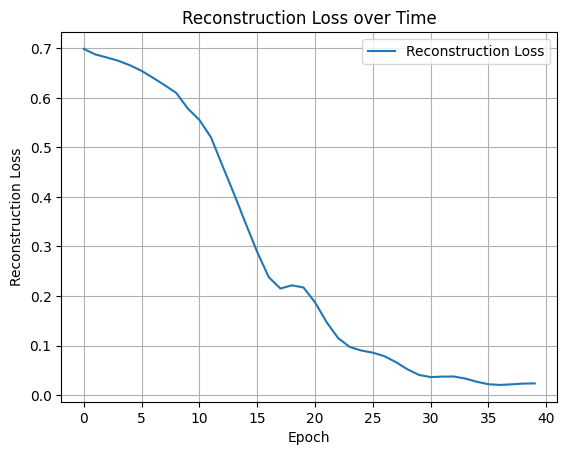

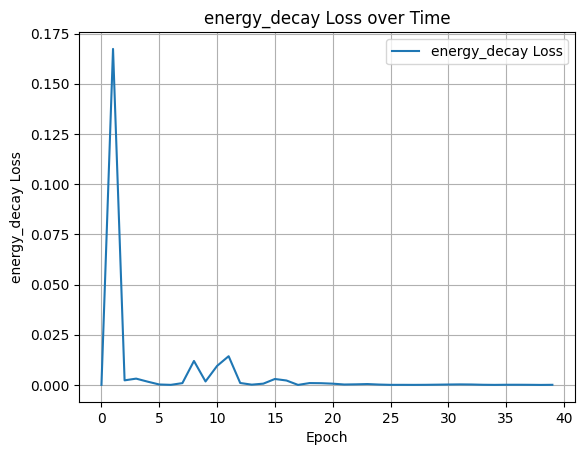

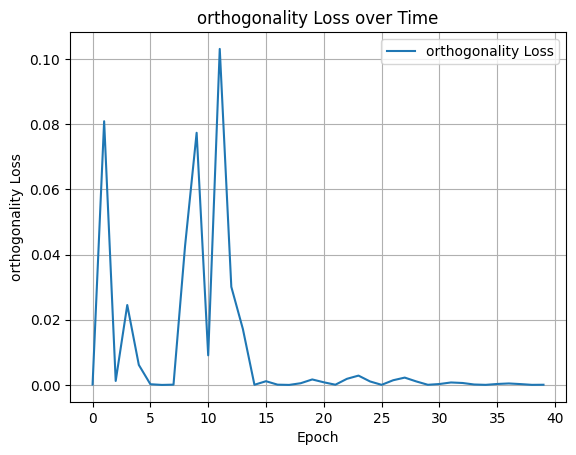

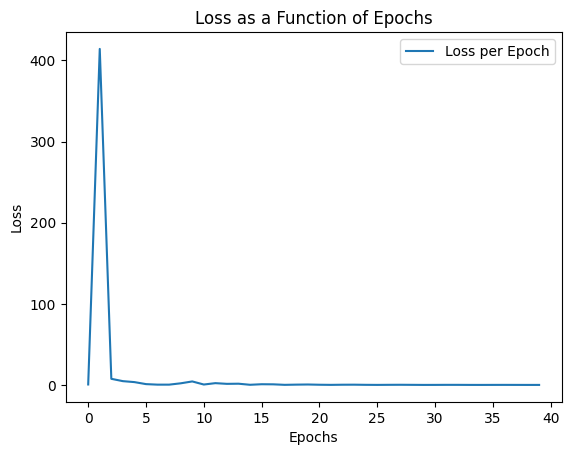

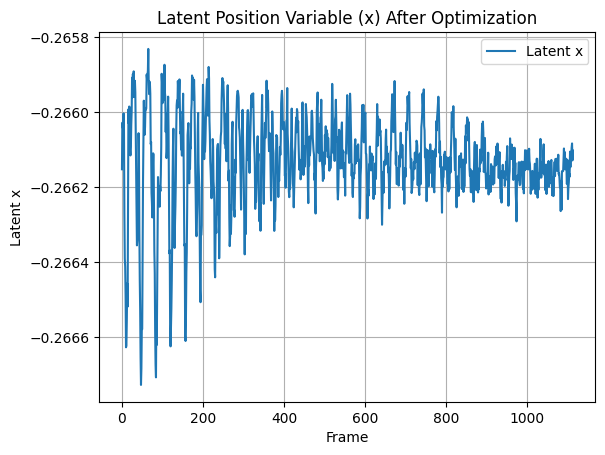

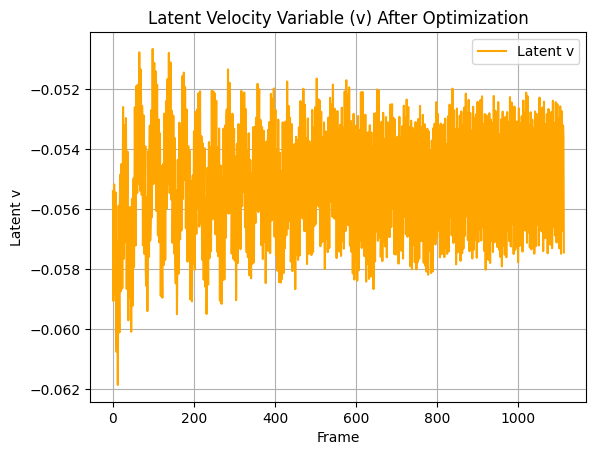

NameError: name 'vel_m_per_frame' is not defined

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from data_processing.data_processing2 import images_tensor
import seaborn as sns
import pandas as pd


class ConvNetAutoencoder_basic(nn.Module):
    def __init__(self, input_shape):
        super(ConvNetAutoencoder_basic, self).__init__()
        self.encoder_conv_layers = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
        )
        # Output Dimension = ((Input dimension +2*padding - kernel_size)/stride) + 1
        # stride is how much we shift after each filter 
        # padding is adding zeros around the edges of your matrix before applying the filter
        # Final dimension is (64,69,25)

        #Dynamically calculate the output shape of the encoder conv layers
        self._get_conv_output(input_shape)

        self.encoder_fc_layers = nn.Sequential(
            nn.Linear(self.num_flat_features, 128),
            nn.ELU(),
            nn.Linear(128, 64),
            nn.ELU(),
            nn.Linear(64, 2),  # Assuming a 2-dimensional latent space
        )

        self.decoder_fc_layers = nn.Sequential(
            nn.Linear(2, 64),
            nn.ELU(),
            nn.Linear(64, 128),
            nn.ELU(),
            nn.Linear(128, self.num_flat_features),
        )

        self.decoder_conv_layers = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
        )
        
    def _get_conv_output(self, shape):
        bs = 1  # Batch size of 1 for testing output shape
        input_tensor = torch.randn(bs, *shape)  # Generate a random tensor without Variable
        with torch.no_grad():  # Disable gradient tracking since this is only for shape calculation
            output_feat = self.encoder_conv_layers(input_tensor)
        self.final_conv_shape = output_feat.shape[1:]  # Store the shape after the last conv layer
        n_size = output_feat.detach().flatten(start_dim=1).size(1)  # Compute flattened size safely
        self.num_flat_features = n_size

    def forward(self, x):
        x = self.encoder_conv_layers(x)
        x = x.view(x.size(0), -1) #Flattening
        x = self.encoder_fc_layers(x)
        latent_vars = x.clone()  # Store latent variables before decoding
        x = self.decoder_fc_layers(x)
        #Use stored shape for dynamic reshaping
        x = x.view(x.size(0), *self.final_conv_shape)
        x = self.decoder_conv_layers(x)
        return x,latent_vars


images_tensor = images_tensor


model = ConvNetAutoencoder_basic(input_shape=(1, 200, 560))
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 40
losses = []
patience = 20
min_delta = 0.01  
latent_epoch_data = []
converged = False
phys_losses = []
reconstruction_losses = []
damped_acceleration_losses = []
energy_decay_losses = []
orthogonality_losses = []

def physics_informed_loss(x, v, lambda_phys=10):
    phys_loss = F.mse_loss(v[:-1], dx_dt_estimated)  # MSE between estimated derivative and velocity
    return lambda_phys * phys_loss

def damped_acceleration_loss(latent_x, latent_v, lambda_damp=20, alpha=0.0292, beta=0.0025):
    acc = latent_v[1:] - latent_v[:-1]  # backward finite difference: dv/dt
    x_trim = latent_x[1:]              # match shape
    v_trim = latent_v[1:]              # same points as acc
    expected_acc = -alpha * x_trim - beta * v_trim
    return lambda_damp * F.mse_loss(acc, expected_acc)

def smoothness_loss(latent, weight=0.1):
    # latent shape: (batch_size, 2)
    dx = latent[1:] - latent[:-1]  # difference between consecutive latent vectors
    smooth = torch.mean(dx**2)    # L2 smoothness loss
    return weight * smooth

for epoch in range(num_epochs):
    if converged:
        break
    model.train()
    optimizer.zero_grad()

    # Forward pass through the model
    reconstructed, latent_vars = model(images_tensor)

    # Standard reconstruction loss
    reconstruction_loss = loss_fn(reconstructed, images_tensor)

    # Extract latent variables assumed as [x, v]
    x, v = latent_vars[:, 0], latent_vars[:, 1]

    # Calculate the physics-informed loss
    phys_loss = physics_informed_loss(x, v)
    
    x, v = latent_vars[:, 0], latent_vars[:, 1]

    smooth_loss = smoothness_loss(latent_vars, weight=0.1)

    damp_loss = damped_acceleration_loss(x, v, lambda_damp=5)

    #energy loss
    # Convert to PyTorch tensors if they're not already
    latent_x_tensor = x
    latent_v_tensor = v
    energy = latent_x_tensor**2 + latent_v_tensor**2
    energy_diff = energy[1:] - energy[:-1]
    energy_decay_loss = F.relu(energy_diff).mean()

    orthogonality_loss = torch.mean(latent_x_tensor * latent_v_tensor)


    #orthg loss
    # Force latent_x and latent_v to be uncorrelated (orthogonal)
    orthogonality_loss = torch.mean((latent_x_tensor * latent_v_tensor)**2)

    # Total loss is the sum of reconstruction loss and physics-informed loss
    total_loss = 0.5*reconstruction_loss + phys_loss + smooth_loss + damp_loss + (5*energy_decay_loss) + orthogonality_loss

    # Backpropagation
    total_loss.backward()
    optimizer.step()

    damped_acceleration_losses.append(damp_loss.item())
    phys_losses.append(phys_loss.item())
    reconstruction_losses.append(reconstruction_loss.item())
    losses.append(total_loss.item())
    energy_decay_losses.append(energy_decay_loss.item())
    orthogonality_losses.append(orthogonality_loss.item())
    print(f"Epoch: {epoch}, Total Loss: {total_loss.item():.4f}")

    # Early stopping logic
    if epoch > 0 and (losses[-2] - losses[-1] < min_delta):
        if patience > 0:
            patience -= 1
        else:
            print("Early stopping as the model has converged.")
            converged = True

    if epoch % 50 == 0:
        latent_epoch_data.append(latent_vars.detach().cpu().numpy())



latent_values = []

model.eval()
# Forward pass to get the latent variable
with torch.no_grad():
    xe = model.encoder_conv_layers(images_tensor)
    xe = xe.view(xe.size(0), -1)
    latent_variable = model.encoder_fc_layers(xe)

# Convert the lists to numpy arrays for plotting
latent_values = latent_variable.numpy() 


plt.plot(damped_acceleration_losses, label='Damped acceleration Loss')
plt.xlabel('Epoch')
plt.ylabel('Damped acceleration Loss')
plt.title('Damped acceleration Loss over Time')
plt.grid(True)
plt.legend()
plt.show()

plt.plot(phys_losses, label='Physics-Informed Loss')
plt.xlabel('Epoch')
plt.ylabel('Physics Loss')
plt.title('Physics-Informed Loss over Time')
plt.grid(True)
plt.legend()
plt.show()

plt.plot(reconstruction_losses, label='Reconstruction Loss')
plt.xlabel('Epoch')
plt.ylabel('Reconstruction Loss')
plt.title('Reconstruction Loss over Time')
plt.grid(True)
plt.legend()
plt.show()

plt.plot(energy_decay_losses, label='energy_decay Loss')
plt.xlabel('Epoch')
plt.ylabel('energy_decay Loss')
plt.title('energy_decay Loss over Time')
plt.grid(True)
plt.legend()
plt.show()

plt.plot(orthogonality_losses, label='orthogonality Loss')
plt.xlabel('Epoch')
plt.ylabel('orthogonality Loss')
plt.title('orthogonality Loss over Time')
plt.grid(True)
plt.legend()
plt.show()

plt.plot(losses, label='Loss per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss as a Function of Epochs')
plt.legend()
plt.show()

latent_x = latent_values[:, 0]
latent_v = latent_values[:, 1]

plt.figure()
plt.plot(latent_x, label='Latent x')
plt.xlabel('Frame')
plt.ylabel('Latent x')
plt.title('Latent Position Variable (x) After Optimization')
plt.grid(True)
plt.legend()
plt.show()

plt.figure()
plt.plot(latent_v, label='Latent v', color='orange')
plt.xlabel('Frame')
plt.ylabel('Latent v')
plt.title('Latent Velocity Variable (v) After Optimization')
plt.grid(True)
plt.legend()
plt.show()


# Normalize both for visual comparison
latent_v_norm = (latent_v - latent_v.min()) / (latent_v.max() - latent_v.min())
real_v_norm = (vel_m_per_frame - vel_m_per_frame.min()) / (vel_m_per_frame.max() - vel_m_per_frame.min())

plt.plot(real_v_norm, label='Real Velocity (normalized)', linestyle='--')
plt.plot(latent_v_norm, label='Latent Velocity (normalized)', alpha=0.7)
plt.xlabel('Frame')
plt.ylabel('Normalized Value')
plt.title('Latent v vs. Real Velocity')
plt.legend()
plt.grid(True)
plt.show()

latent_x_norm = (latent_x - latent_x.min()) / (latent_x.max() - latent_x.min())
real_x_norm = (positions_m - positions_m.min()) / (positions_m.max() - positions_m.min())

plt.plot(real_x_norm, label='Real Position (normalized)', linestyle='--')
plt.plot(latent_x_norm, label='Latent Position (normalized)', alpha=0.7)
plt.xlabel('Frame')
plt.ylabel('Normalized Value')
plt.title('Latent x vs. Real Position')
plt.legend()
plt.grid(True)
plt.show()


# Use backward finite difference
dx_dt_from_latent = latent_x[1:] - latent_x[:-1]  # shape: (T - 1,)
latent_v_trimmed = latent_v[1:]                   # match shape (T - 1,)

# Normalize both
dx_dt_norm = (dx_dt_from_latent - dx_dt_from_latent.min()) / (dx_dt_from_latent.max() - dx_dt_from_latent.min())
latent_v_norm = (latent_v_trimmed - latent_v_trimmed.min()) / (latent_v_trimmed.max() - latent_v_trimmed.min())

# Plot
plt.figure(figsize=(10, 4))
plt.plot(dx_dt_norm, label='dx/dt from latent x (backward diff)', linestyle='--')
plt.plot(latent_v_norm, label='latent v', alpha=0.7)
plt.xlabel('Frame')
plt.ylabel('Normalized Value')
plt.title('Latent v vs. dx/dt of Latent x (Using Backward Difference)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()



alpha = 0.0292
beta = 0.0025

# Approximate d²x/dt² using backward finite difference on v
ddx_latent = latent_v[1:] - latent_v[:-1]  # shape: (T - 1,)

# Match time alignment for x and v
x_trim = latent_x[1:]                      # shape: (T - 1,)
v_trim = latent_v[1:]                      # shape: (T - 1,)
expected_acc = -alpha * x_trim - beta * v_trim

# Plot
plt.figure(figsize=(10, 4))
plt.plot(ddx_latent, label='d²x_latent/dt² ≈ v[t] - v[t-1]', linestyle='--')
plt.plot(expected_acc, label='-αx - βv', alpha=0.7)
plt.xlabel('Frame')
plt.ylabel('Acceleration')
plt.title('Latent Acceleration vs. Expected Damped Acceleration (Backward Difference)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


energy = latent_x**2 + latent_v**2
plt.plot(energy)
plt.xlabel('Frame')
plt.ylabel('Latent Energy')
plt.title('Latent Energy Over Time')
plt.grid(True)
plt.show()




SINDy Model (Finite Difference Derivatives):
(x0)' = -0.002 x1
(x1)' = -0.051 1 + -0.853 x1 + 0.004 x0^2 + 0.228 x0 x1 + 0.094 x1^2


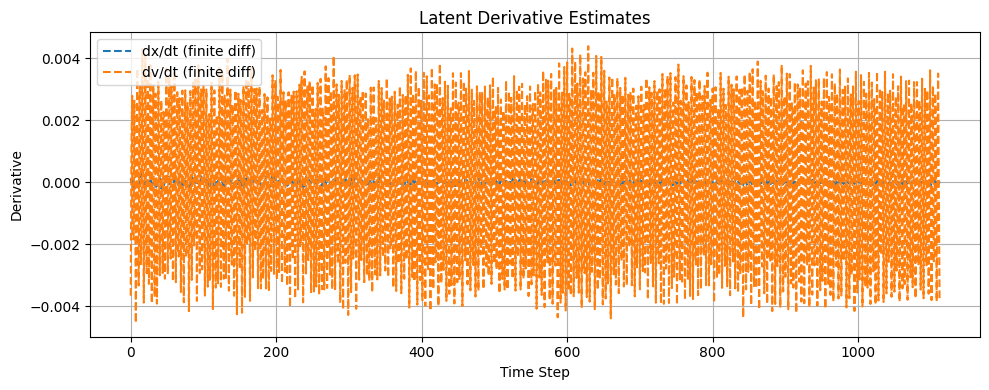

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pysindy as ps
from scipy.signal import savgol_filter


X = np.stack([latent_x, latent_v], axis=1)  
dt = 1  

X_dot_fd = (X[1:] - X[:-1]) / dt
X_fd = X[:-1]  # align sizes

model_fd = ps.SINDy(optimizer=ps.STLSQ(threshold=1e-5), feature_library=ps.PolynomialLibrary(degree=2))
model_fd.fit(X_fd, t=dt, x_dot=X_dot_fd)
print("SINDy Model (Finite Difference Derivatives):")
model_fd.print()

plt.figure(figsize=(10, 4))
plt.plot(X_dot_fd[:, 0], label='dx/dt (finite diff)', linestyle='--')
plt.plot(X_dot_fd[:, 1], label='dv/dt (finite diff)', linestyle='--')
plt.xlabel('Time Step')
plt.ylabel('Derivative')
plt.title('Latent Derivative Estimates')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

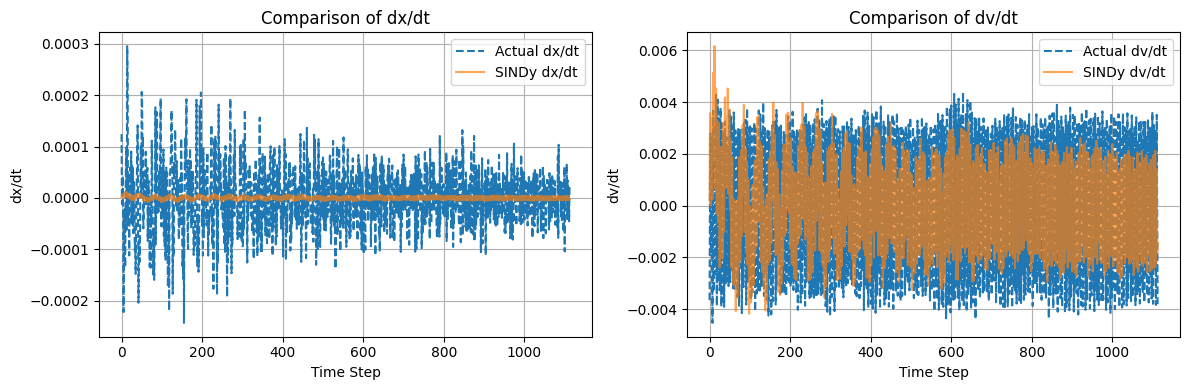

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pysindy as ps

latent_x = latent_values[:, 0]
latent_v = latent_values[:, 1]
X = np.stack([latent_x, latent_v], axis=1)
dt = 1  # Time step

X_dot_fd = (X[1:] - X[:-1]) / dt
X_fd = X[:-1]  

model = ps.SINDy(optimizer=ps.STLSQ(threshold=1e-5), feature_library=ps.PolynomialLibrary(degree=2))
model.fit(X_fd, t=dt, x_dot=X_dot_fd)
X_dot_pred = model.predict(X_fd)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(X_dot_fd[:, 0], label='Actual dx/dt', linestyle='--')
plt.plot(X_dot_pred[:, 0], label='SINDy dx/dt', alpha=0.7)
plt.title('Comparison of dx/dt')
plt.xlabel('Time Step')
plt.ylabel('dx/dt')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(X_dot_fd[:, 1], label='Actual dv/dt', linestyle='--')
plt.plot(X_dot_pred[:, 1], label='SINDy dv/dt', alpha=0.7)
plt.title('Comparison of dv/dt')
plt.xlabel('Time Step')
plt.ylabel('dv/dt')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()